# # SaaS Company (AWS) Sales Exploratory Data Analysis

This notebook performs exploratory data analysis (EDA) on the sales data of a Software as a Service (SaaS) company, in the specific Amazon AWS, from 2020 to 2023. [Click here to see the dataset on Kaggle](https://www.kaggle.com/datasets/7750efed2f8651cf0e0ac9d161d36b9916dada803898bb585dbf67b6bd9d8c23).

If we find some linear relationship with at least one of the sales metrics in the data, we will perform linear regression to predict sales.

## Table of contents

1. [Import the libraries](#import-libraries)
2. [Explore and clean the data](#explore-and-clean-the-data)
3. [Inspect correlations](#inspect-correlations)
4. [Reduce outlayers](#reduce-outlayers)
5. [Encode non-numerical variables](#encode-non-numerical-variables)
6. [Normalize the data](#normalize-the-data)
7. [EDA and preprocessing conclusions](#eda-and-preprocessing-conclusions)

## Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [2]:
data_cleaned = pd.read_pickle('SaaS_sales_data_cleaned.pkl')
data_500 = pd.read_pickle('data_500.pkl')
data_500_1000 = pd.read_pickle('data_500_1000.pkl')
top_correlated_features_data = pd.read_pickle('top_correlated_features_data.pkl')
standardized_data = pd.read_pickle('standardized_data.pkl')

## Explore and clean the data

### Load the dataset

In [2]:
# Load the data
data = pd.read_csv('SaaS-Sales.csv')

# Convert the data to a pickle file so it can be loaded later on without re-loading the csv file.
data.to_pickle('SaaS_sales_dataset.pkl')

# Show the first few values
data.head()

Row ID          Order ID  Order Date  Date Key    Contact Name  \
0       1  EMEA-2022-152156   11/9/2022  20221109     Nathan Bell   
1       2  EMEA-2022-152156   11/9/2022  20221109     Nathan Bell   
2       3  AMER-2022-138688   6/13/2022  20220613  Deirdre Bailey   
3       4  EMEA-2021-108966  10/11/2021  20211011      Zoe Hodges   
4       5  EMEA-2021-108966  10/11/2021  20211011      Zoe Hodges   

         Country           City Region Subregion           Customer  \
0        Ireland         Dublin   EMEA      UKIR            Chevron   
1        Ireland         Dublin   EMEA      UKIR            Chevron   
2  United States  New York City   AMER     NAMER        Phillips 66   
3        Germany      Stuttgart   EMEA   EU-WEST  Royal Dutch Shell   
4        Germany      Stuttgart   EMEA   EU-WEST  Royal Dutch Shell   

   Customer ID Industry    Segment                 Product     License  \
0         1017   Energy        SMB         Marketing Suite  16GRM07R1K   
1         1017   Energy        SMB              FinanceHub  QLIW57KZUV   
2         1056   Energy  Strategic              FinanceHub  JI6BVL70HQ   
3         1031   Energy        SMB          ContactMatcher  DE9GJKGD44   
4         1031   Energy        SMB  Marketing Suite - Gold  OIF7NY23WD   

      Sales  Quantity  Discount    Profit  
0  261.9600         2      0.00   41.9136  
1  731.9400         3      0.00  219.5820  
2   14.6200         2      0.00    6.8714  
3  957.5775         5      0.45 -383.0310  
4   22.3680         2      0.20    2.5164

### Get some basic information from the data

Now we need to get some basic information on the dataset to asses the data types and non-null values for every cplumn.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Row ID        9994 non-null   int64  
 1   Order ID      9994 non-null   object 
 2   Order Date    9994 non-null   object 
 3   Date Key      9994 non-null   int64  
 4   Contact Name  9994 non-null   object 
 5   Country       9994 non-null   object 
 6   City          9994 non-null   object 
 7   Region        9994 non-null   object 
 8   Subregion     9994 non-null   object 
 9   Customer      9994 non-null   object 
 10  Customer ID   9994 non-null   int64  
 11  Industry      9994 non-null   object 
 12  Segment       9994 non-null   object 
 13  Product       9994 non-null   object 
 14  License       9994 non-null   object 
 15  Sales         9994 non-null   float64
 16  Quantity      9994 non-null   int64  
 17  Discount      9994 non-null   float64
 18  Profit        9994 non-null 

Wonderful, it looks like each column is in the data type it should be in (even if we'd like to have the date in a datetime format), and also every column as the same amount of non-null values, which is a sign indicating that probably we won't find any null value.

### Check for missing values and duplicates

Even if probably there won't be any missing value, we still better double check.

Text(0.5, 1.0, 'Total Missing values')

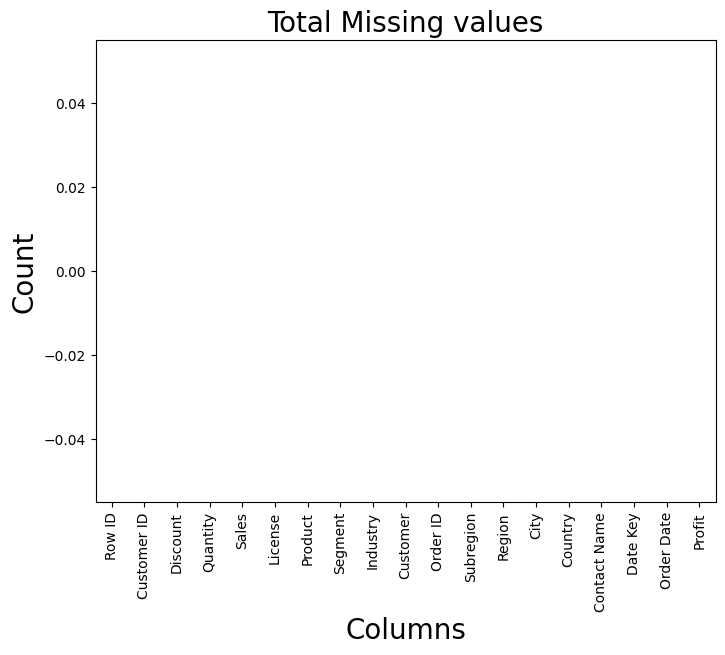

In [9]:
total_missing = data.isnull().sum().sort_values(ascending=False)
total_missing_select = total_missing
total_missing_select.plot(kind='bar', figsize = (8,6), fontsize = 10)

plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize  = 20)
plt.title("Total Missing values", fontsize = 20)

Amazing, as suspected, there are no missing values in our dataset!

Before looking at the descriptive statitstics, we need also to check for duplicate values, which my skew the distribution of the data. We are going to use "Row ID" as unique identifier of each order, which according to the author of the dataset is "A unique identifier for each transaction."

In [11]:
duplicate = data[data.duplicated(['Row ID'], keep=False)]
duplicate.count()

Row ID          0
Order ID        0
Order Date      0
Date Key        0
Contact Name    0
Country         0
City            0
Region          0
Subregion       0
Customer        0
Customer ID     0
Industry        0
Segment         0
Product         0
License         0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

There is no duplicate Row ID in the dataset. However, let's check more thoroughly for potential duplicates. There are many entries with the same Order ID, Date Key, Contact Name, Country, CIty, Region, etc., which is not a problem because multiple products might be sold in a single deal. However, it would be a red flag if the Product was the same too.

In [13]:
duplicate_multiple_attributes = data[data.duplicated(['Order ID', 'Order Date', 'Date Key', 'Product'], keep=False)]
duplicate.count()

Row ID          0
Order ID        0
Order Date      0
Date Key        0
Contact Name    0
Country         0
City            0
Region          0
Subregion       0
Customer        0
Customer ID     0
Industry        0
Segment         0
Product         0
License         0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

Great, there are 0 red flags, so so it's safe to say that there are not duplicates in this dataset.

### Convert "Order Date"

Even if we don't need it right now, we should convert the Order Date from 'object' type to 'datetime' type. The date has a "MMDDYYYY" format(Dtype "object"), whereas the Date Key has a "YYYYMMDD" format (Dtype "int64"). We should convert one of the two and remove the other to avoid redundancy.

Converting "object" Dtypes into datetime is generally easier, so we are going to convert "Order Date" and drop "Date Key".

In [23]:
# Convert to datetime
data['Order Date Datetime'] = pd.to_datetime(data['Order Date'], format='%m/%d/%Y')
data.to_pickle('SaaS_sales_dataset.pkl')

# Print the first five rows to check if the conversion was successful
data.head(5)

Row ID          Order ID  Order Date  Date Key    Contact Name  \
0       1  EMEA-2022-152156   11/9/2022  20221109     Nathan Bell   
1       2  EMEA-2022-152156   11/9/2022  20221109     Nathan Bell   
2       3  AMER-2022-138688   6/13/2022  20220613  Deirdre Bailey   
3       4  EMEA-2021-108966  10/11/2021  20211011      Zoe Hodges   
4       5  EMEA-2021-108966  10/11/2021  20211011      Zoe Hodges   

         Country           City Region Subregion           Customer  \
0        Ireland         Dublin   EMEA      UKIR            Chevron   
1        Ireland         Dublin   EMEA      UKIR            Chevron   
2  United States  New York City   AMER     NAMER        Phillips 66   
3        Germany      Stuttgart   EMEA   EU-WEST  Royal Dutch Shell   
4        Germany      Stuttgart   EMEA   EU-WEST  Royal Dutch Shell   

   Customer ID Industry    Segment                 Product     License  \
0         1017   Energy        SMB         Marketing Suite  16GRM07R1K   
1         1017   Energy        SMB              FinanceHub  QLIW57KZUV   
2         1056   Energy  Strategic              FinanceHub  JI6BVL70HQ   
3         1031   Energy        SMB          ContactMatcher  DE9GJKGD44   
4         1031   Energy        SMB  Marketing Suite - Gold  OIF7NY23WD   

      Sales  Quantity  Discount    Profit Order Date Datetime  
0  261.9600         2      0.00   41.9136          2022-11-09  
1  731.9400         3      0.00  219.5820          2022-11-09  
2   14.6200         2      0.00    6.8714          2022-06-13  
3  957.5775         5      0.45 -383.0310          2021-10-11  
4   22.3680         2      0.20    2.5164          2021-10-11

The data looks good, now let's assess the Dtypes again.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Row ID               9994 non-null   int64         
 1   Order ID             9994 non-null   object        
 2   Order Date           9994 non-null   object        
 3   Date Key             9994 non-null   int64         
 4   Contact Name         9994 non-null   object        
 5   Country              9994 non-null   object        
 6   City                 9994 non-null   object        
 7   Region               9994 non-null   object        
 8   Subregion            9994 non-null   object        
 9   Customer             9994 non-null   object        
 10  Customer ID          9994 non-null   int64         
 11  Industry             9994 non-null   object        
 12  Segment              9994 non-null   object        
 13  Product              9994 non-nul

You can see a 20th column with the date in the datetime format. Now we can remove the rendundat date columns.

In [36]:
data_cleaned = data.drop(['Order Date', 'Date Key'], axis=1)
data_cleaned.to_pickle('SaaS_sales_data_cleaned.pkl')
data_cleaned.head()

Row ID          Order ID    Contact Name        Country           City  \
0       1  EMEA-2022-152156     Nathan Bell        Ireland         Dublin   
1       2  EMEA-2022-152156     Nathan Bell        Ireland         Dublin   
2       3  AMER-2022-138688  Deirdre Bailey  United States  New York City   
3       4  EMEA-2021-108966      Zoe Hodges        Germany      Stuttgart   
4       5  EMEA-2021-108966      Zoe Hodges        Germany      Stuttgart   

  Region Subregion           Customer  Customer ID Industry    Segment  \
0   EMEA      UKIR            Chevron         1017   Energy        SMB   
1   EMEA      UKIR            Chevron         1017   Energy        SMB   
2   AMER     NAMER        Phillips 66         1056   Energy  Strategic   
3   EMEA   EU-WEST  Royal Dutch Shell         1031   Energy        SMB   
4   EMEA   EU-WEST  Royal Dutch Shell         1031   Energy        SMB   

                  Product     License     Sales  Quantity  Discount    Profit  \
0         Marketing Suite  16GRM07R1K  261.9600         2      0.00   41.9136   
1              FinanceHub  QLIW57KZUV  731.9400         3      0.00  219.5820   
2              FinanceHub  JI6BVL70HQ   14.6200         2      0.00    6.8714   
3          ContactMatcher  DE9GJKGD44  957.5775         5      0.45 -383.0310   
4  Marketing Suite - Gold  OIF7NY23WD   22.3680         2      0.20    2.5164   

  Order Date Datetime  
0          2022-11-09  
1          2022-11-09  
2          2022-06-13  
3          2021-10-11  
4          2021-10-11

### Describe the data

Now that we have seen the basic info and the shape of the dataset, we want see some basic descriptive statistics of the numerical values in the dataset.

In [37]:
data_cleaned.describe()

Row ID  Customer ID         Sales     Quantity     Discount  \
count  9994.000000  9994.000000   9994.000000  9994.000000  9994.000000   
mean   4997.500000  1049.771963    229.858001     3.789574     0.156203   
min       1.000000  1001.000000      0.444000     1.000000     0.000000   
25%    2499.250000  1024.000000     17.280000     2.000000     0.000000   
50%    4997.500000  1049.000000     54.490000     3.000000     0.200000   
75%    7495.750000  1076.000000    209.940000     5.000000     0.200000   
max    9994.000000  1101.000000  22638.480000    14.000000     0.800000   
std    2885.163629    29.719388    623.245101     2.225110     0.206452   

            Profit            Order Date Datetime  
count  9994.000000                           9994  
mean     28.656896  2022-05-01 00:07:12.259355648  
min   -6599.978000            2020-01-04 00:00:00  
25%       1.728750            2021-05-23 00:00:00  
50%       8.666500            2022-06-27 00:00:00  
75%      29.364000            2023-05-15 00:00:00  
max    8399.976000            2023-12-31 00:00:00  
std     234.260108                            NaN

We can easily see that AWS has beeen profitable in the selected date range. However, we can also see that the mean of both sales and profitability are very close to the 75th percentile, and this means that there there are fewer bigger deals that contribute to the majority of sales; this is further confirmed but the extremely high standard deviation of these two attributes. On the other hand, the quantity of sales look more normally distributed, being the mean and 50th percentile much closer. Last but not least, there seems to be low variability in the discount rate, with a standard deviation of 20.65% and a mean of 15.62%, also by looking at the 50th and 75th percetiles, which have the same value (20%), we can see that most discounts are of 20%.

Now that we have seen and interpreted the basic descriptive statistics, we should dive deeper and plot the distributions of each of these key attributes.

### Data distributions

In [3]:
# Helper function to plot the distributions
def plot_distribution(value_to_plot, xmin, xlim, value_name):
    plt.figure(figsize=(14, 8))

    # Create histogram
    value_distribution = sns.histplot(value_to_plot, bins=150, kde=False)
    # Even if it will take out some of the precision, we are going to set a number of bins
    # to better see the data

    # Set x-axis to cover the full range of Sales values
    plt.xlim(xmin, xlim)

    # Set y-axis to cover up to the maximum count of occurrences
    plt.ylim(0, value_distribution.get_figure().axes[0].get_ylim()[1])

    # Add titles and labels
    plt.title(f'{value_name} Distribution')
    plt.xlabel('Sales')
    plt.ylabel('Count')

    plt.show()

In [5]:
# Helper function to plot the distributions of two attributes
def plot_distribution_2(value_to_plot1, value_to_plot2, xmin, xlim, value_name1, value_name2):
    plt.figure(figsize=(14, 8))

    # Create histograms
    sns.histplot(value_to_plot1, bins=150, kde=False, color='blue', label=value_name1, alpha=0.6)
    sns.histplot(value_to_plot2, bins=150, kde=False, color='red', label=value_name2, alpha=0.6)

    # Set x-axis to cover the full range of Sales values
    plt.xlim(xmin, xlim)

    # Set y-axis to cover up to the maximum count of occurrences
    plt.ylim(0, plt.gca().get_ylim()[1])

    # Add titles and labels
    plt.title(f'Distribution of {value_name1} and {value_name2}')
    plt.xlabel('Sales')
    plt.ylabel('Count')
    
    # Add a legend to differentiate between the two attributes
    plt.legend()

    plt.show()


In [6]:
# Helper function to plot the distributions
def plot_distribution_no_bins(value_to_plot, xmin, xlim, value_name):
    plt.figure(figsize=(14, 8))

    # Create histogram
    value_distribution = sns.histplot(value_to_plot, kde=False)
    # Even if it will take out some of the precision, we are going to set a number of bins
    # to better see the data

    # Set x-axis to cover the full range of Sales values
    plt.xlim(xmin, xlim)

    # Set y-axis to cover up to the maximum count of occurrences
    plt.ylim(0, value_distribution.get_figure().axes[0].get_ylim()[1])

    # Add titles and labels
    plt.title(f'{value_name} Distribution')
    plt.xlabel('Sales')
    plt.ylabel('Count')

    plt.show()

In [7]:
# Helper function to plot the scatter plot
def plot_scatter(value_to_plot, xmin, xlim, value_name):
    plt.figure(figsize=(14, 8))

    # Generate x values as the index of each data point
    x_values = range(len(value_to_plot))
    
    # Create scatter plot
    plt.scatter(x_values, value_to_plot, alpha=0.6)

    # Set x-axis to cover the full range of indices
    plt.xlim(0, len(value_to_plot))
    
    # Set y-axis to cover the specified range of Sales values
    plt.ylim(xmin, xlim)

    # Add titles and labels
    plt.title(f'{value_name} Scatter Plot')
    plt.xlabel('Index')
    plt.ylabel(value_name)

    plt.show()


#### Sales Vs Profit distribution

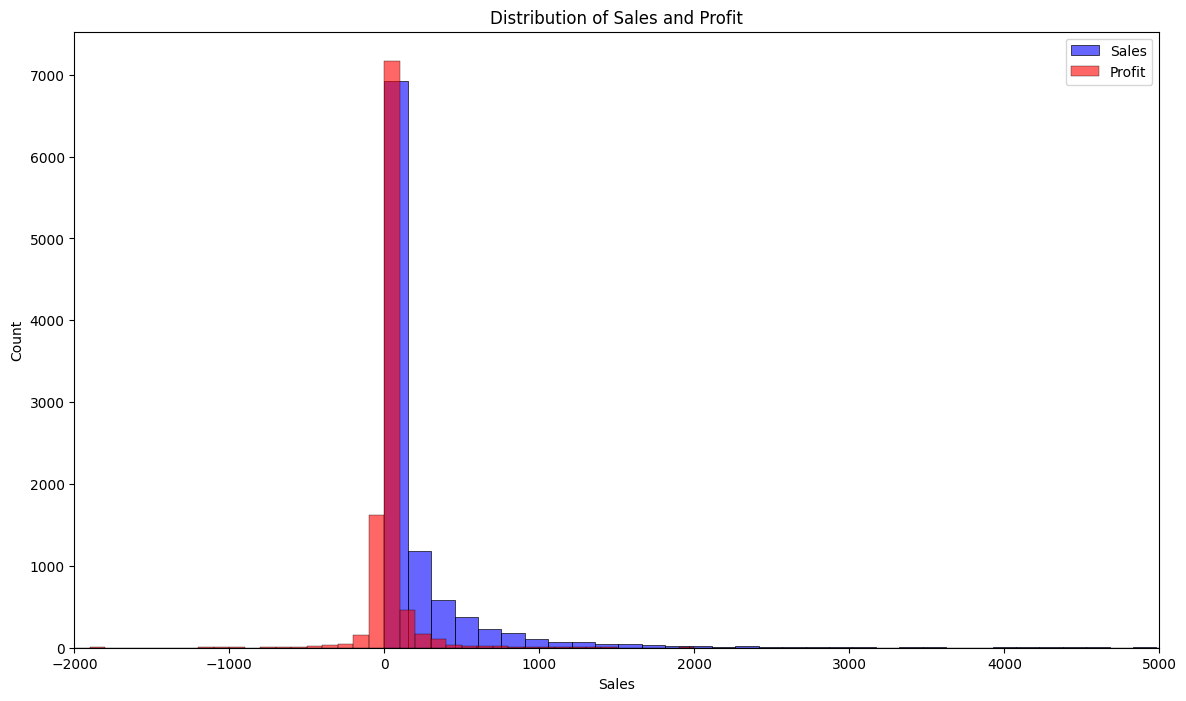

In [64]:
value_to_plot1 = data_cleaned['Sales']
value_to_plot2 = data_cleaned['Profit']

xmin = -2000

#Limit the x-axes to the max number of sales visible by naked eye
xlim = 5000

value_name1 = 'Sales'
value_name2 = 'Profit'

plot_distribution_2(value_to_plot1, value_to_plot2, xmin, xlim, value_name1, value_name2)

We can already see the profits and sales distribution are linearly correlated, but if we look at the tale, we cannot see any profit, at list via naked eye.

We'll further limit the max value on the x-axes to zoom in and better look at our values.

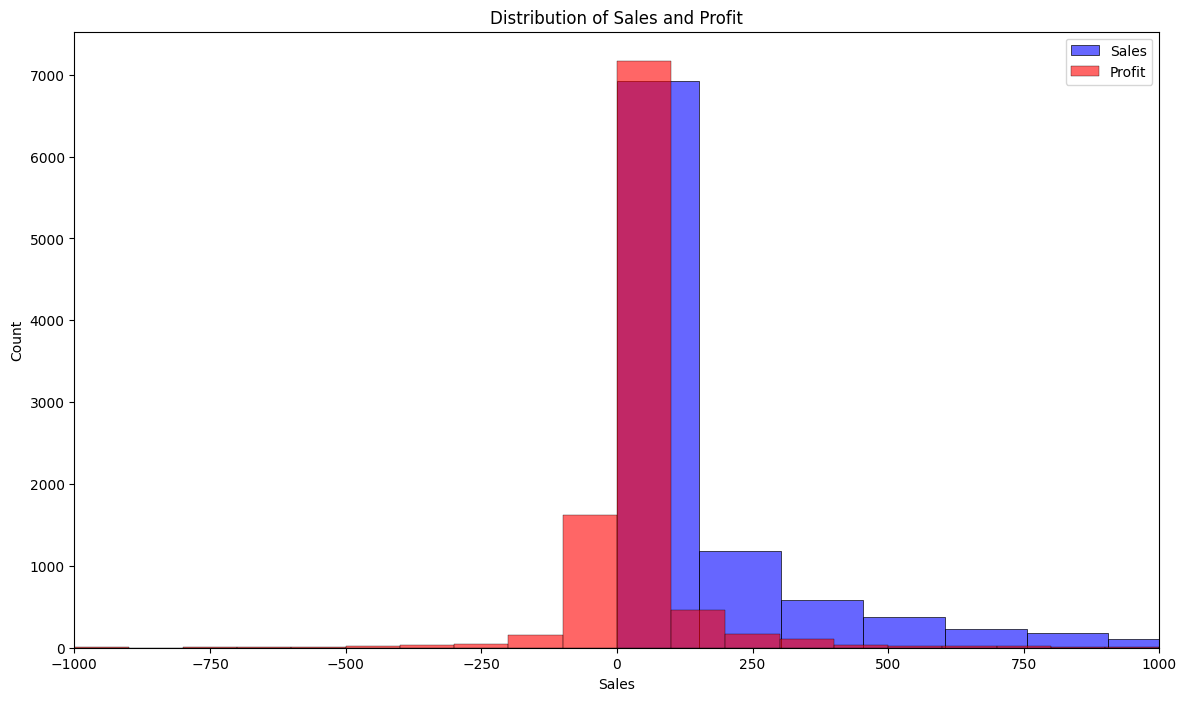

In [65]:
value_to_plot1 = data_cleaned['Sales']
value_to_plot2 = data_cleaned['Profit']

xmin = -1000

#Limit the x-axes to the max number of profit visible by naked eye
xlim = 1000

value_name1 = 'Sales'
value_name2 = 'Profit'

plot_distribution_2(value_to_plot1, value_to_plot2, xmin, xlim, value_name1, value_name2)

Here we can see that we have more profits on the low end area (around 0). This is because some small deals result in a loss. The management should investigate this issue to potentially adjust pricing or align the objectives of the sales department, to sell only above a certain treshold and avoid losses.

Let's set a new minimum treshold to validate our hypotesis.

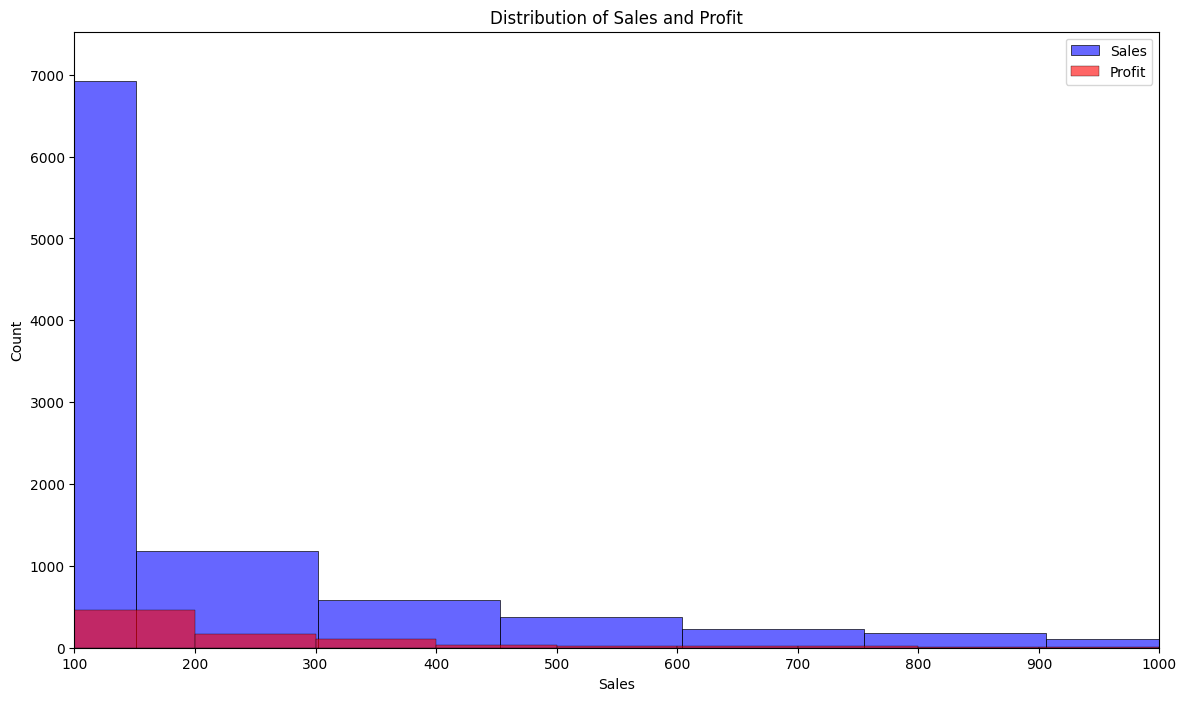

In [127]:
value_to_plot1 = data_cleaned['Sales']
value_to_plot2 = data_cleaned['Profit']

xmin = 100

#Limit the x-axes to the max number of profit visible by naked eye
xlim = 1000

value_name1 = 'Sales'
value_name2 = 'Profit'

plot_distribution_2(value_to_plot1, value_to_plot2, xmin, xlim, value_name1, value_name2)

As we can see, the phenomenon doesn't happen anymore if we move our minimum away from the 0-100 area.

#### Sales distribution

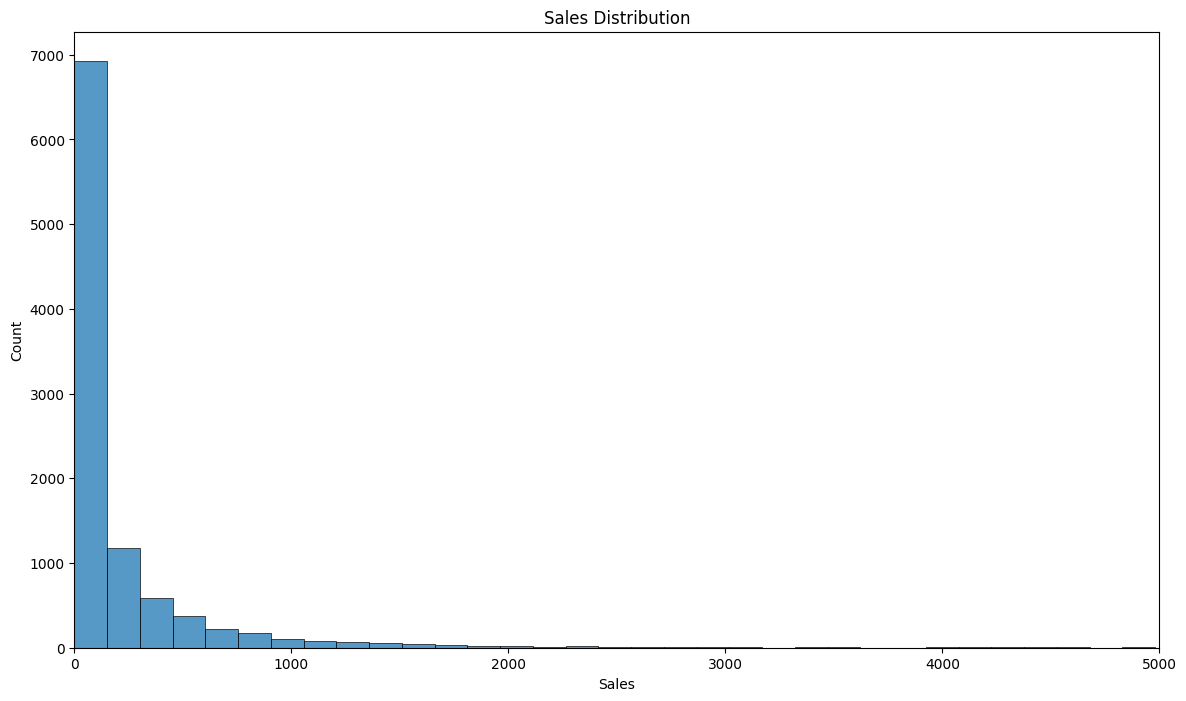

In [31]:
value_to_plot = data_cleaned['Sales']

xmin = 0

#We set a maximum value for the x axis, because there are many impercettible outlayers
#That would make the plot too long
xlim = 5000

value_name = 'Sales'

plot_distribution(value_to_plot,xmin, xlim,value_name)

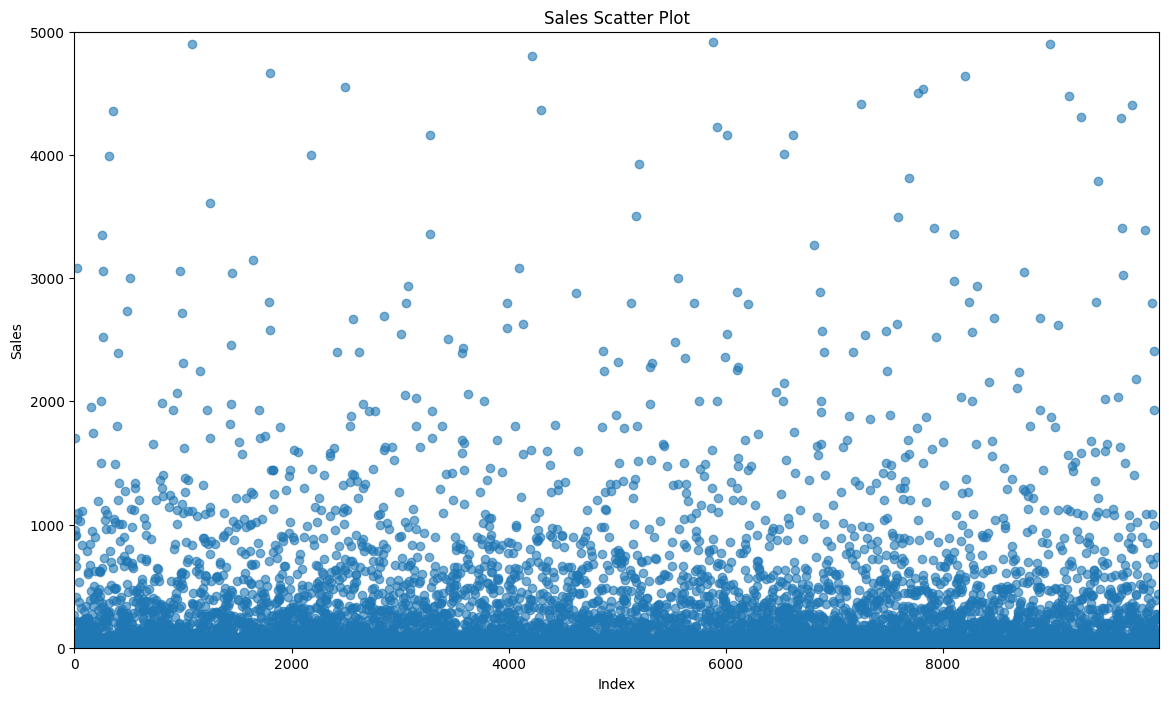

In [47]:
value_to_plot = data_cleaned['Sales']

xmin = 0

#We set a maximum value for the x axis, because there are many impercettible outlayers
#That would make the plot too long
xlim = 5000

value_name = 'Sales'

plot_scatter(value_to_plot, xmin, xlim, value_name)

In these two charts we can't see clear outlayers, but we can draw a line above 2000.

In [3]:
print("Skewness: %f" % data_cleaned['Sales'].skew())

Skewness: 12.972752


Let's zoom into the data.

In [132]:
filtered_data = data_cleaned[data_cleaned['Sales'] > 1000]['Sales']

In [133]:
print(filtered_data.describe())
print(filtered_data.head())

count      468.000000
mean      2115.745897
std       1947.083340
min       1000.020000
25%       1211.596000
50%       1519.419000
75%       2276.615000
max      22638.480000
Name: Sales, dtype: float64
10    1706.184
24    1044.630
27    3083.430
35    1097.544
54    1029.950
Name: Sales, dtype: float64


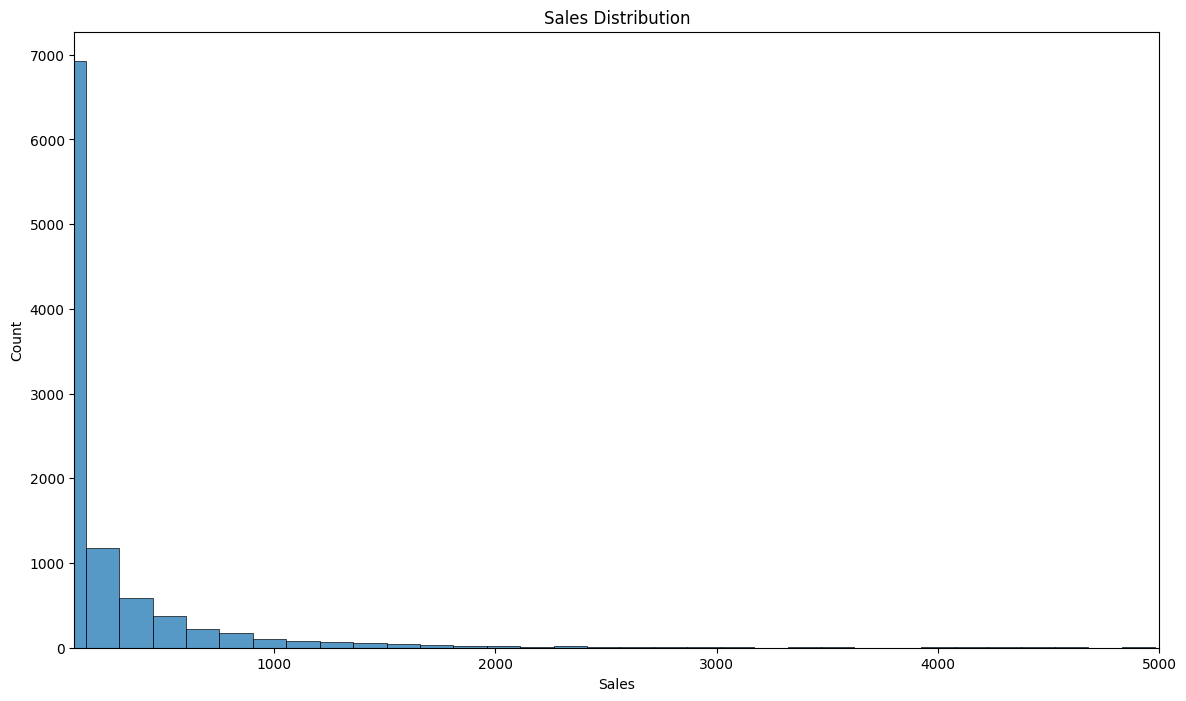

In [134]:
value_to_plot = data_cleaned['Sales']

xmin = 100

#We set a maximum value for the x axis, because there are many impercettible outlayers
#That would make the plot too long
xlim = 5000

value_name = 'Sales'

plot_distribution(value_to_plot,xmin,xlim,value_name)

#### Profit distribution

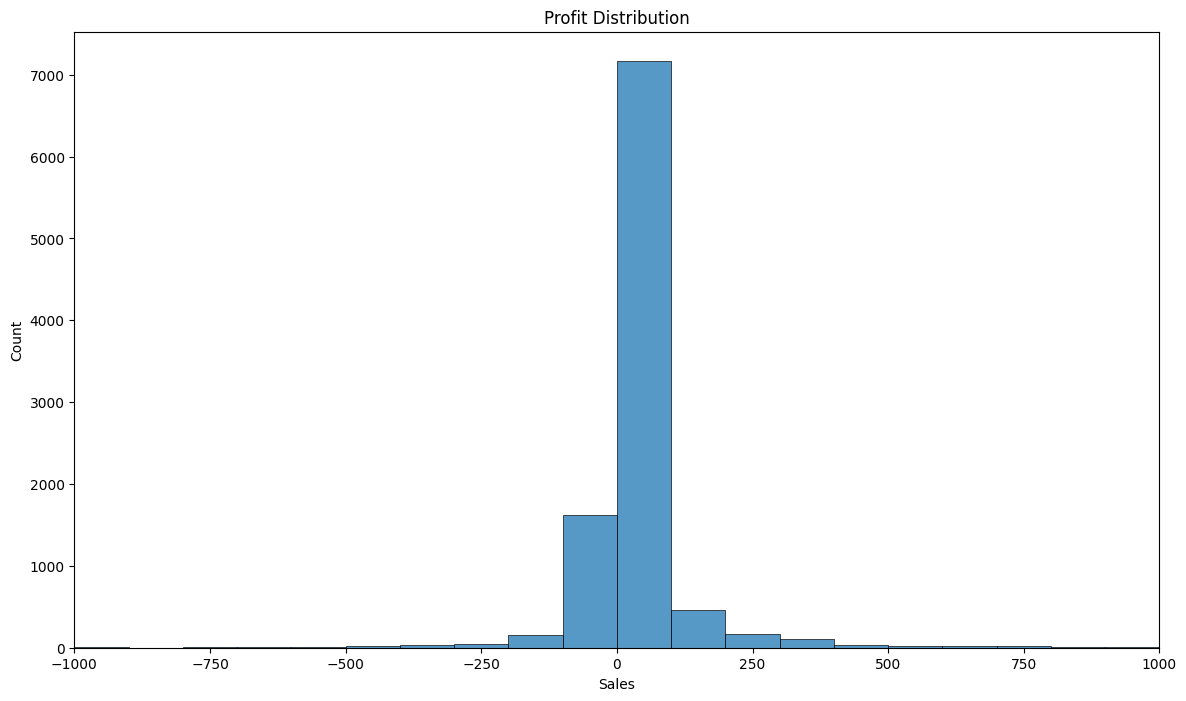

In [59]:
value_to_plot = data_cleaned['Profit']

xmin = -1000

#We set a maximum value for the x axis, because there are many impercettible outlayers
#That would make the plot too long
xlim = 1000

value_name = 'Profit'

plot_distribution(value_to_plot,xmin,xlim,value_name)

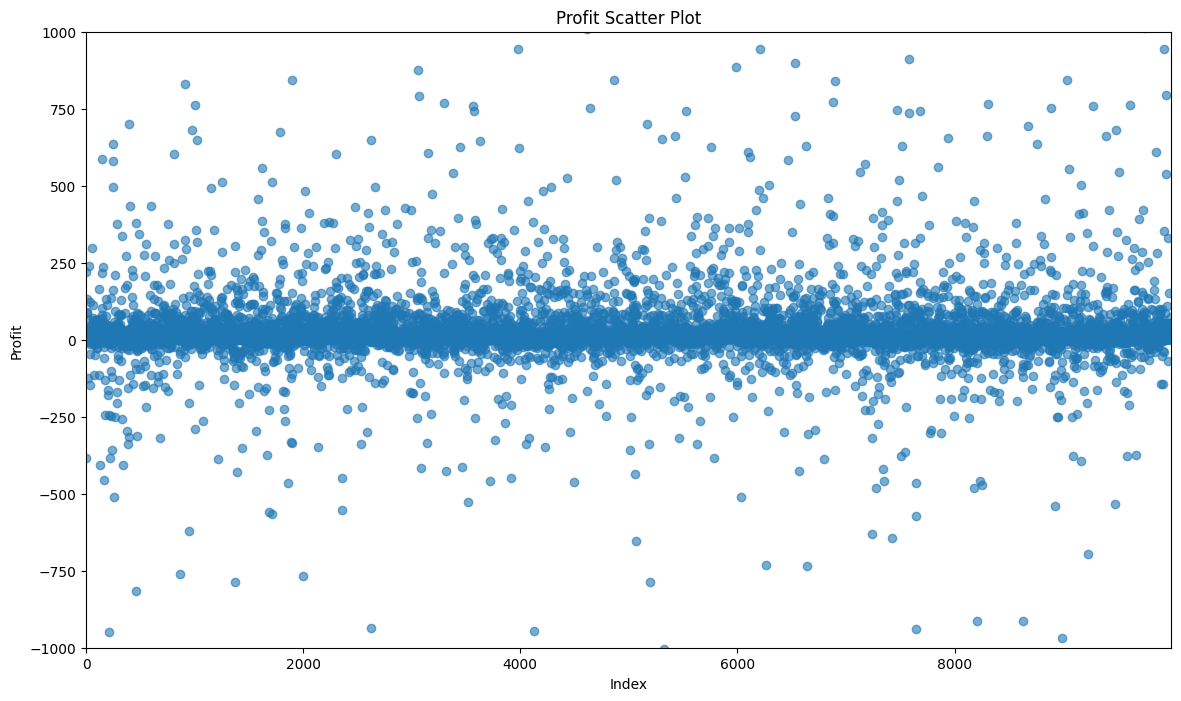

In [60]:
value_to_plot = data_cleaned['Profit']

xmin = -1000

#We set a maximum value for the x axis, because there are many impercettible outlayers
#That would make the plot too long
xlim = 1000

value_name = 'Profit'

plot_scatter(value_to_plot, xmin, xlim, value_name)

We can see that the distribution looks almost even, and limiting the data from -500 to 500 would help with outlayers.

In [61]:
print("Skewness: %f" % data_cleaned['Profit'].skew())

Skewness: 7.561432


However, even if the distribution visually looks close to normal, it's actually far from it, but removing outlayers could potentially help.

#### Quantity distribution

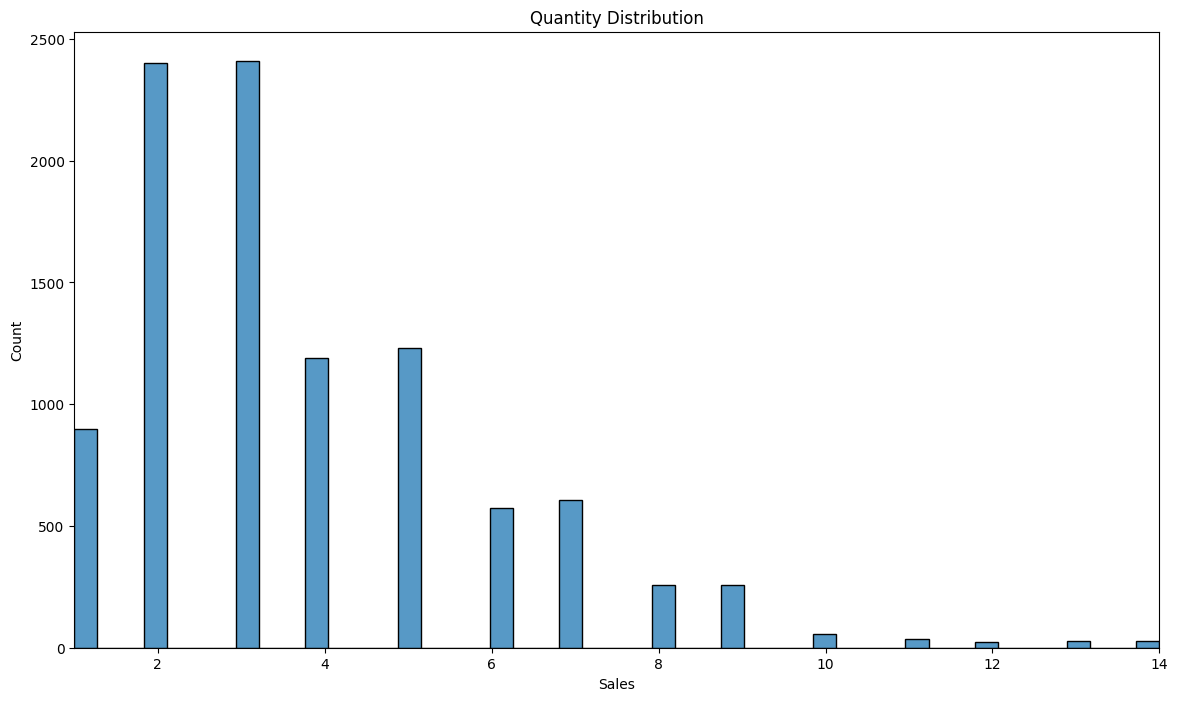

In [66]:
value_to_plot = data_cleaned['Quantity']

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Quantity'

plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

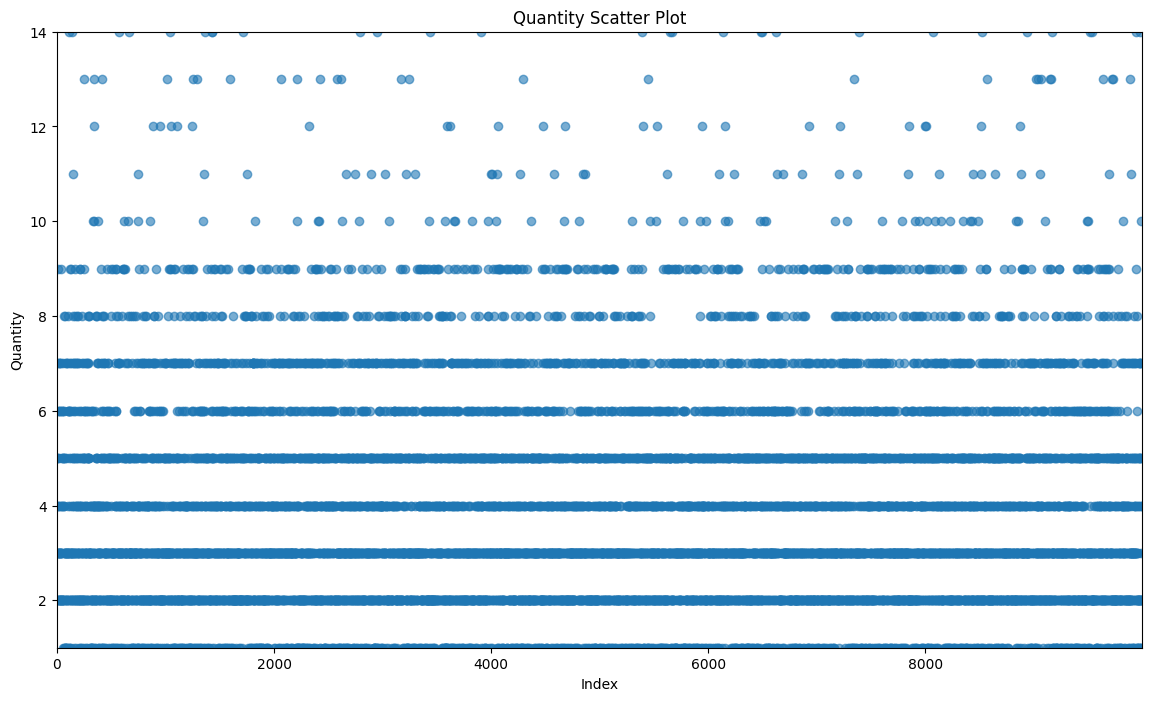

In [67]:
value_to_plot = data_cleaned['Quantity']

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Quantity'

plot_scatter(value_to_plot, xmin, xlim, value_name)

In [5]:
print("Skewness: %f" % data_cleaned['Quantity'].skew())

Skewness: 1.278545


#### Discount distribution

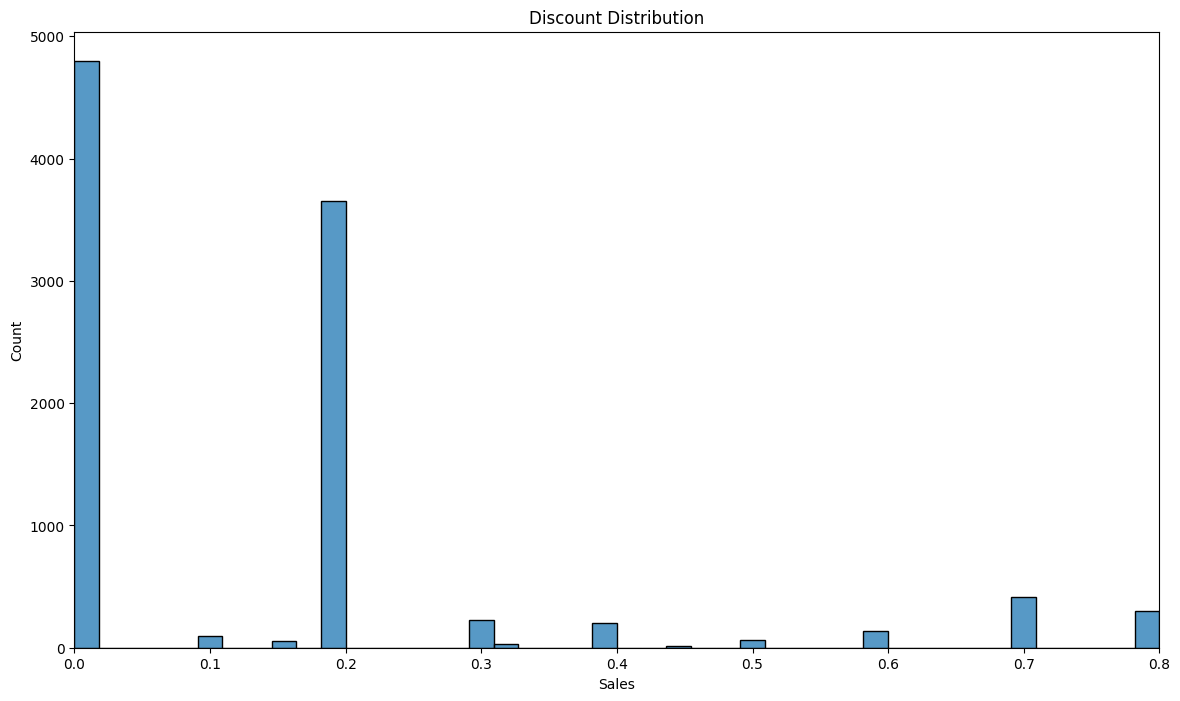

In [68]:
value_to_plot = data_cleaned['Discount']

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Discount'

plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

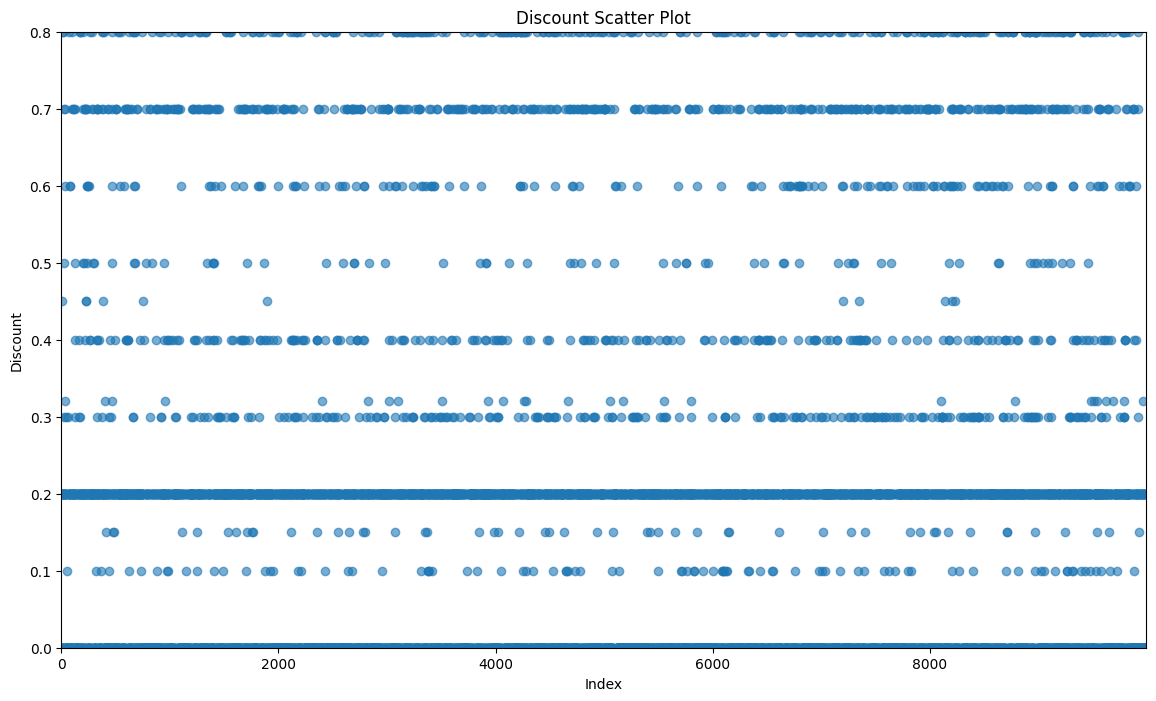

In [69]:
value_to_plot = data_cleaned['Discount']

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Discount'

plot_scatter(value_to_plot, xmin, xlim, value_name)

In [6]:
print("Skewness: %f" % data_cleaned['Discount'].skew())

Skewness: 1.684295


As we can see, the data is too skewed to consider it for linear regression. Therefore, we will probably need to deal with outlyaers. Before doing so, let's try to reduce skewness by log trasforming the data.

### Trasformed data distributions

Some variables have negative values, so we cannot simply use a log or a Box-Cox tranformation. Therefore, we are going to try a few tranformation teachniques to represent the data and maintain consistency. Of course, we will need to use the same transformation teachnique for all variables, but we will also use the logarithmic tranformation for the positive variables for analytical purposes. At the end we will going to select one tranformation or no tranformation at all, if we feel that transformation has taken the data distribution farther away a normal distribution.

#### Log transformation with bias

The first attempt will be trying to apply a logarithmic transformation to all variables, by applying a bias to each one of them and making all positives. However, this type of transformation may make the interpretability of the data more difficult later on, even if it is still possible to easily revert back to the original values.

In [70]:
attributes = ['Sales', 'Profit', 'Quantity', 'Discount']
transformed_data = {}

for attr in attributes:
    shift_value = abs(data_cleaned[attr].min()) + 1
    transformed_data[attr] = np.log(data_cleaned[attr] + shift_value)
    print(f"Skewness of {attr}: %f" % transformed_data[attr].skew())


Skewness of Sales: 0.313661
Skewness of Profit: -83.116332
Skewness of Quantity: 0.369157
Skewness of Discount: 1.316102


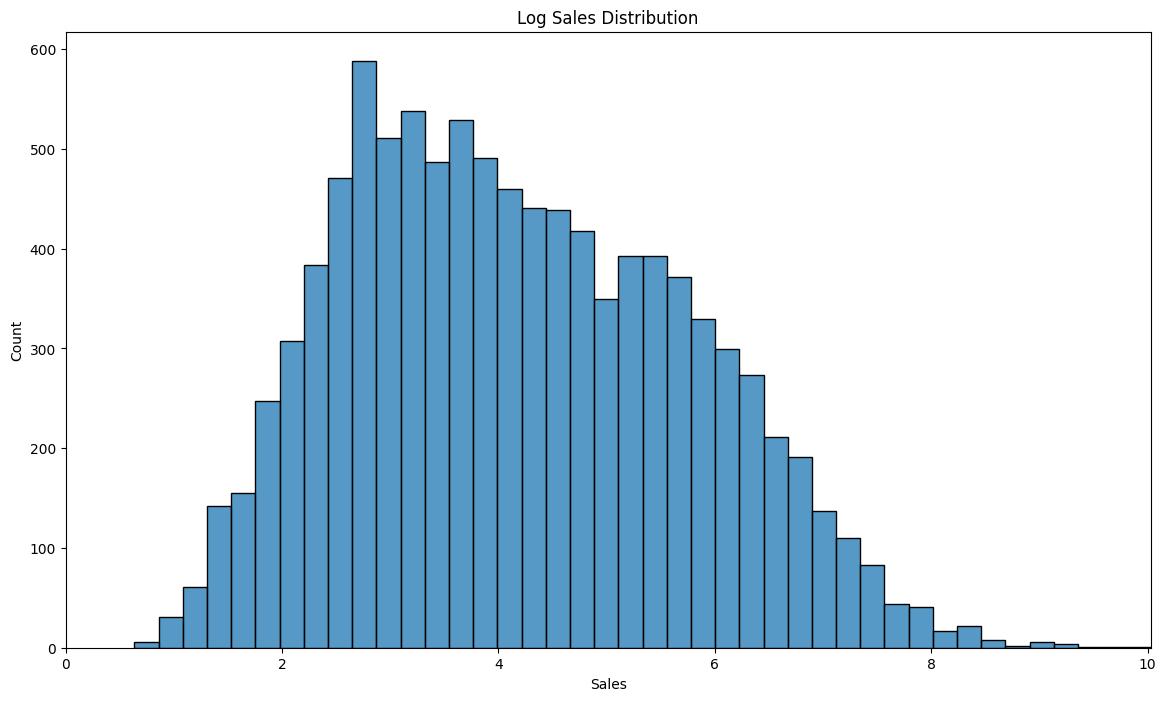

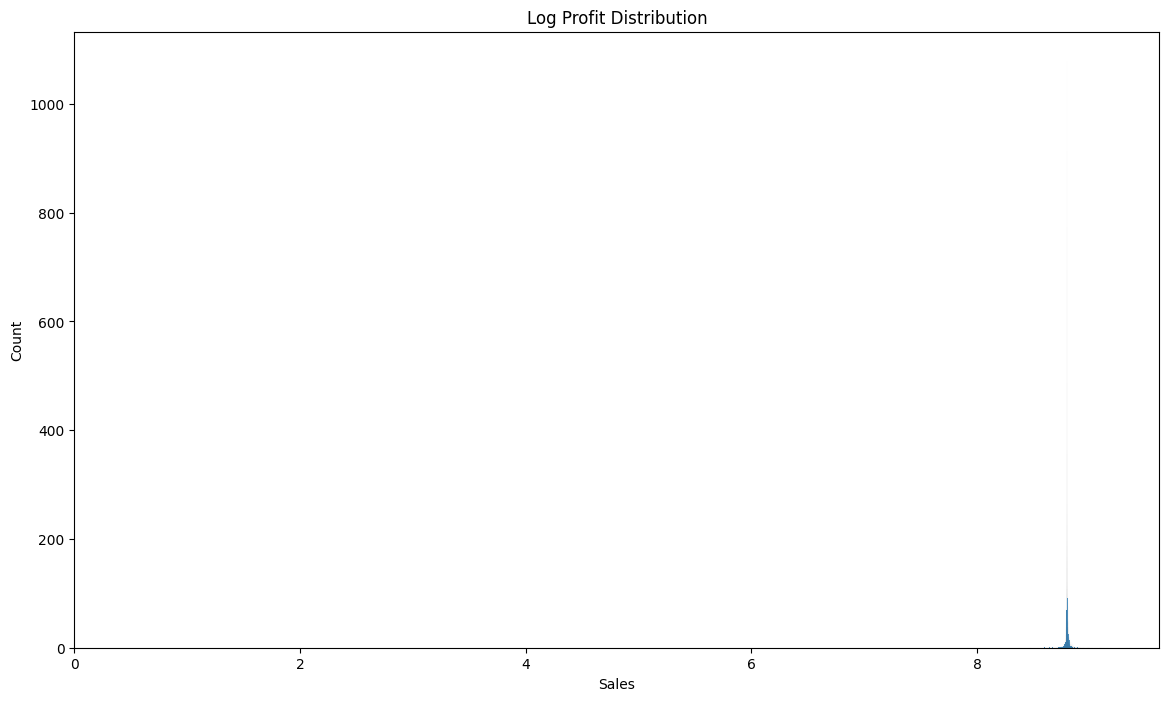

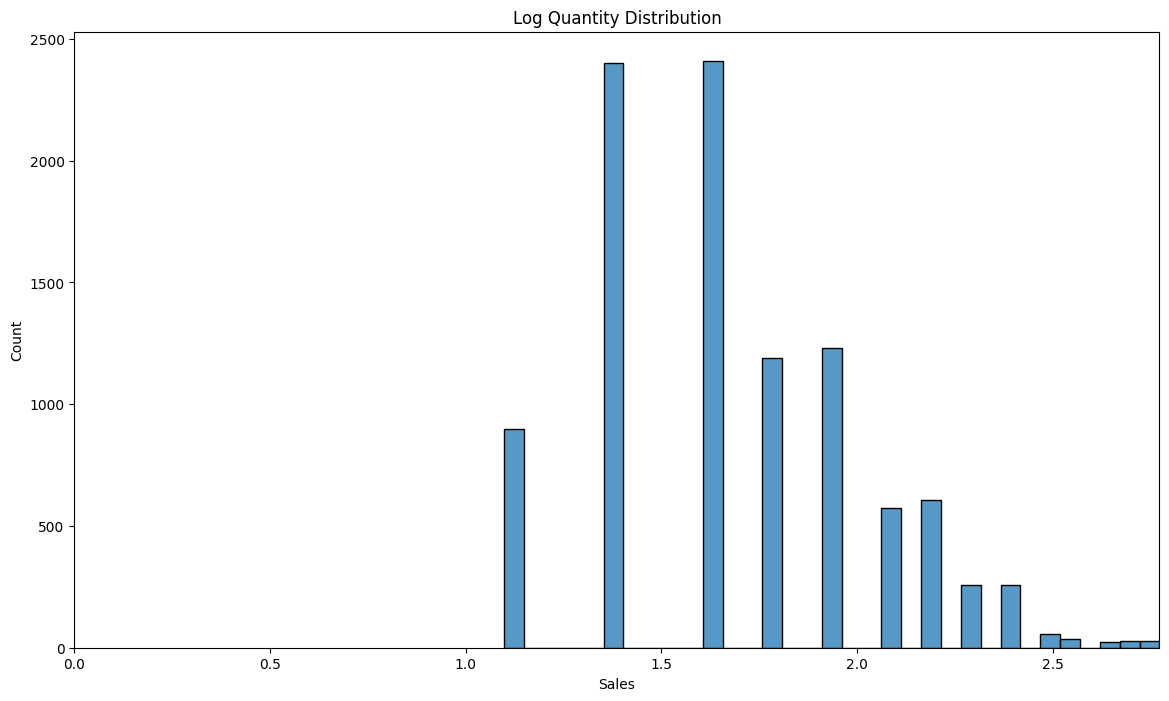

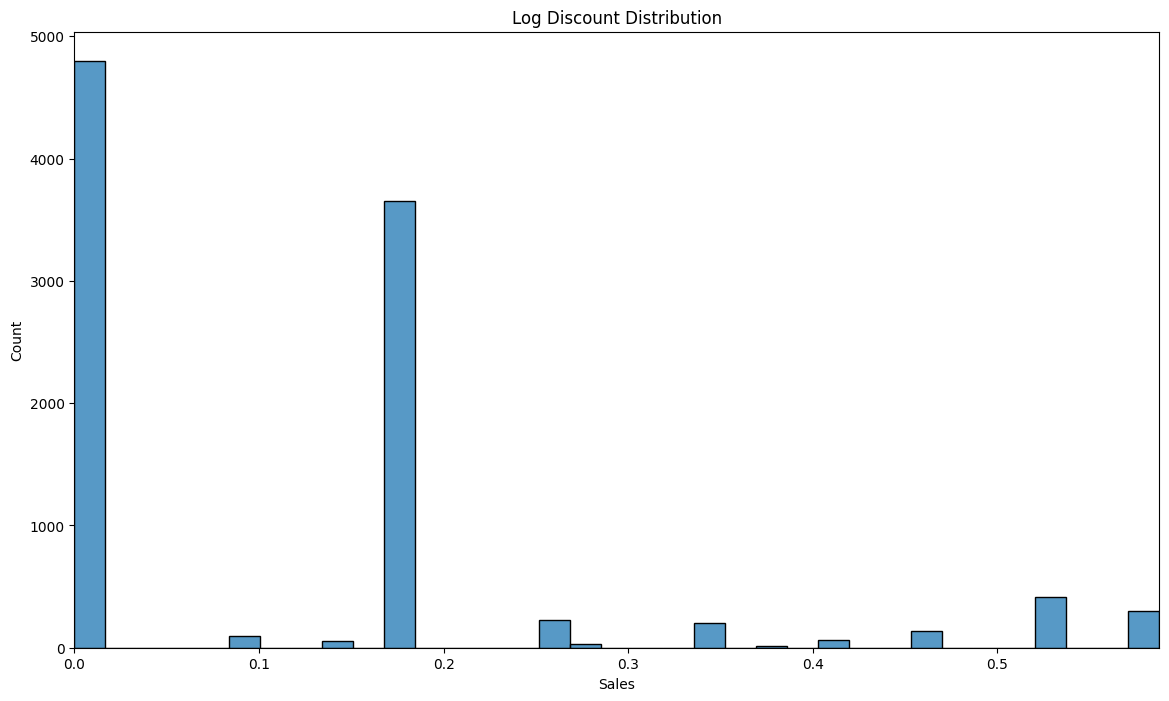

In [15]:
attributes = ['Sales', 'Profit', 'Quantity', 'Discount']

for attr in attributes:
    value_to_plot = transformed_data[attr]

    xmin = 0
    xlim = value_to_plot.max()

    value_name = f'Log {attr}'

    plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

This transformation is not working well, especially but not only for the presence of outlayers.

#### Transformed sales distribution

##### Log transformation

In [13]:
log_transformed_sales = np.log(data_cleaned['Sales'])
print("Skewness: %f" % log_transformed_sales.skew())

Skewness: 0.188648


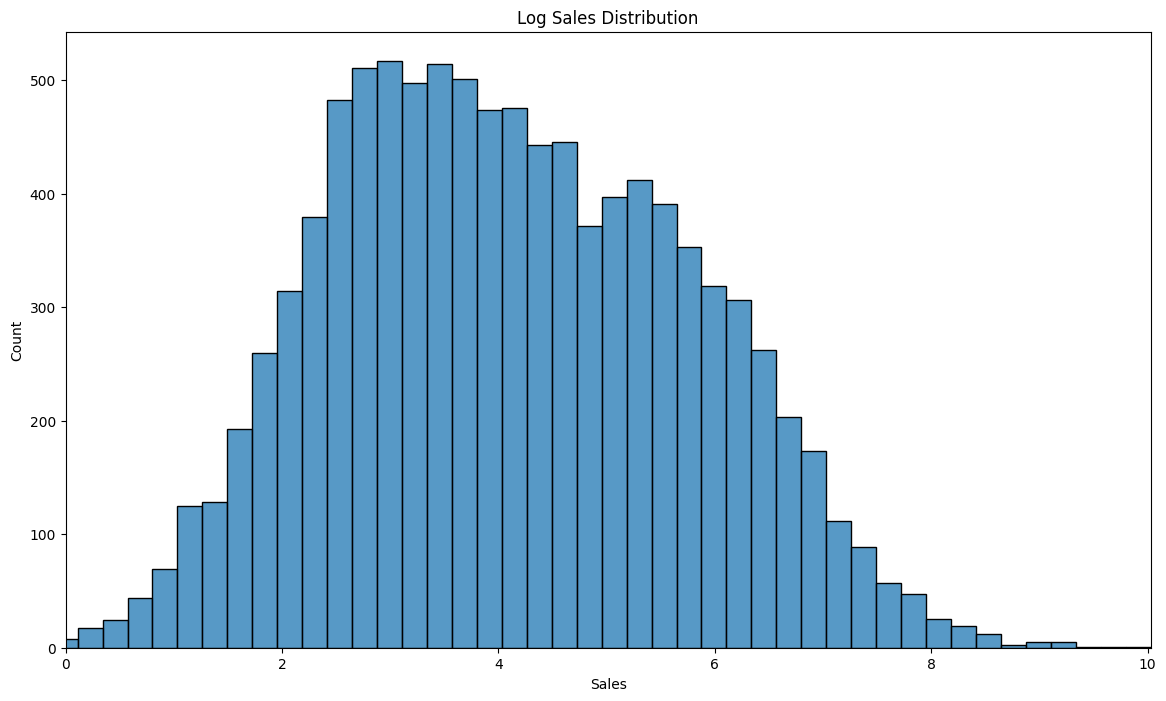

In [36]:
value_to_plot = log_transformed_sales

xmin = 0
xlim = value_to_plot.max()

value_name = 'Log Sales'

plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

##### Cubic root transformation

In [80]:
cube_root_transformed_sales = np.cbrt(data_cleaned['Sales'])
print("Skewness: %f" % cube_root_transformed_sales.skew())

Skewness: 1.595959


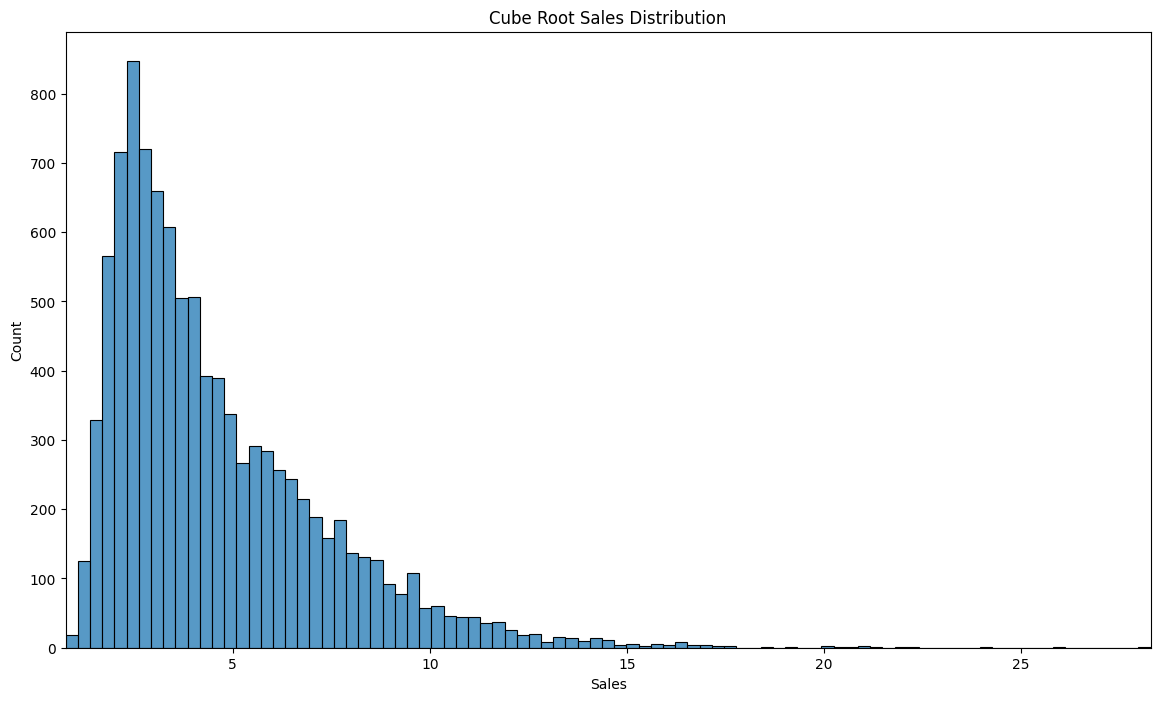

In [81]:
value_to_plot = cube_root_transformed_sales

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Cube Root Sales'

plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

In [ ]:
shift_value = abs(data_cleaned['Discount'].min()) + 1
log_transformed_discount = np.log(data_cleaned['Discount'] + shift_value)


#### Transformed profit distribution

##### Cubic root transformation

In [4]:
data_cleaned = pd.read_pickle('SaaS_sales_data_cleaned.pkl')

In [76]:
cube_root_transformed_profit = np.cbrt(data_cleaned['Profit'])
print("Skewness: %f" % cube_root_transformed_profit.skew())


Skewness: -0.738572


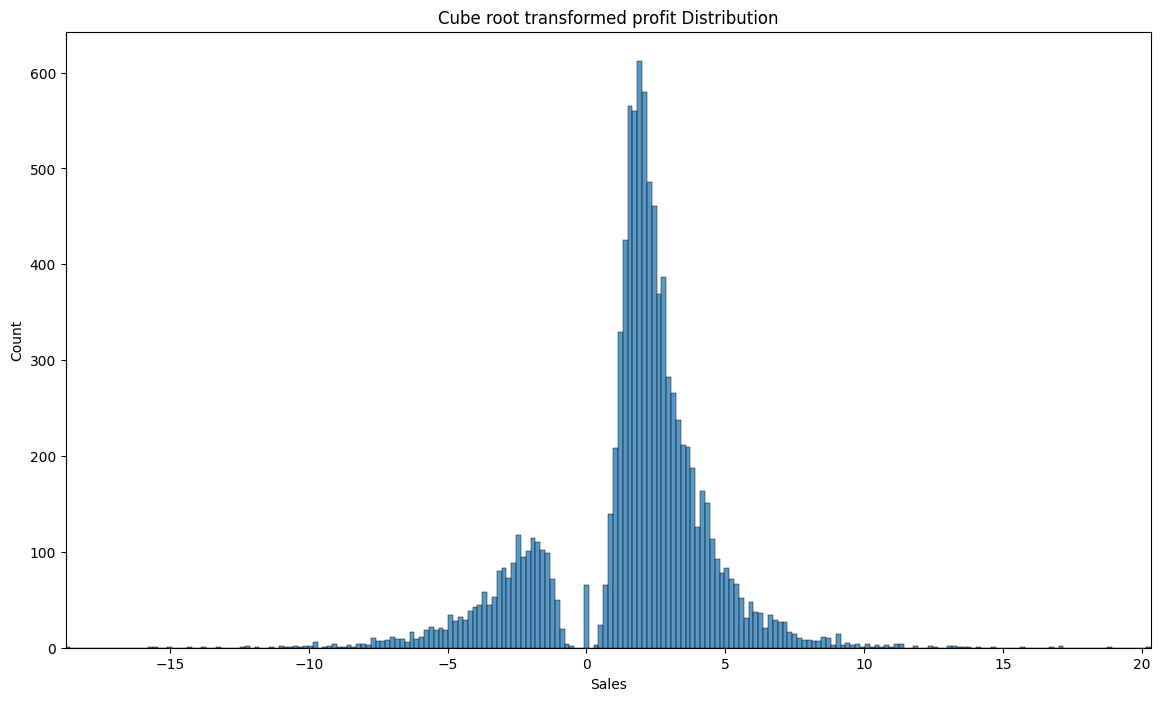

In [78]:
value_to_plot = cube_root_transformed_profit

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Cube root transformed profit'

plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

#### Transformed quantity distribution

##### Log transformation

In [16]:
log_transformed_quantity = np.log(data_cleaned['Quantity'])
print("Skewness: %f" % log_transformed_quantity.skew())

Skewness: -0.147863


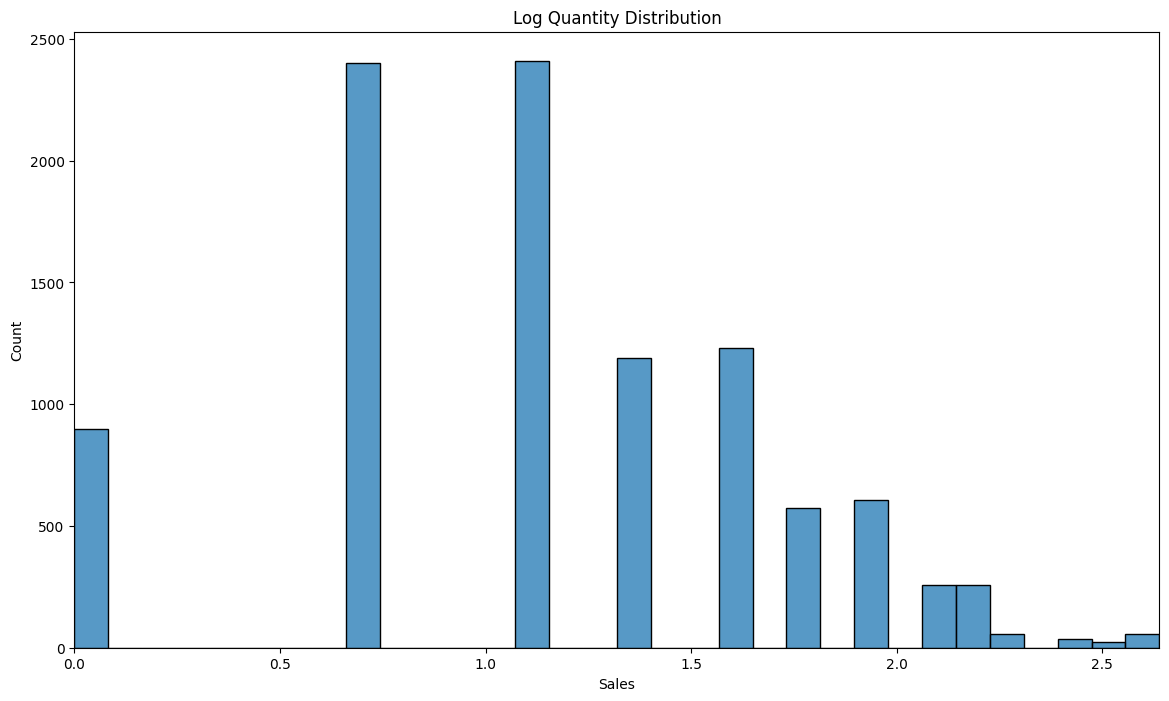

In [37]:
value_to_plot = log_transformed_quantity

xmin = 0
xlim = value_to_plot.max()

value_name = 'Log Quantity'

plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

##### Cubic root transformation

In [71]:
cube_root_transformed_quantity = np.cbrt(data_cleaned['Quantity'])
print("Skewness: %f" % cube_root_transformed_quantity.skew())


Skewness: 0.320667


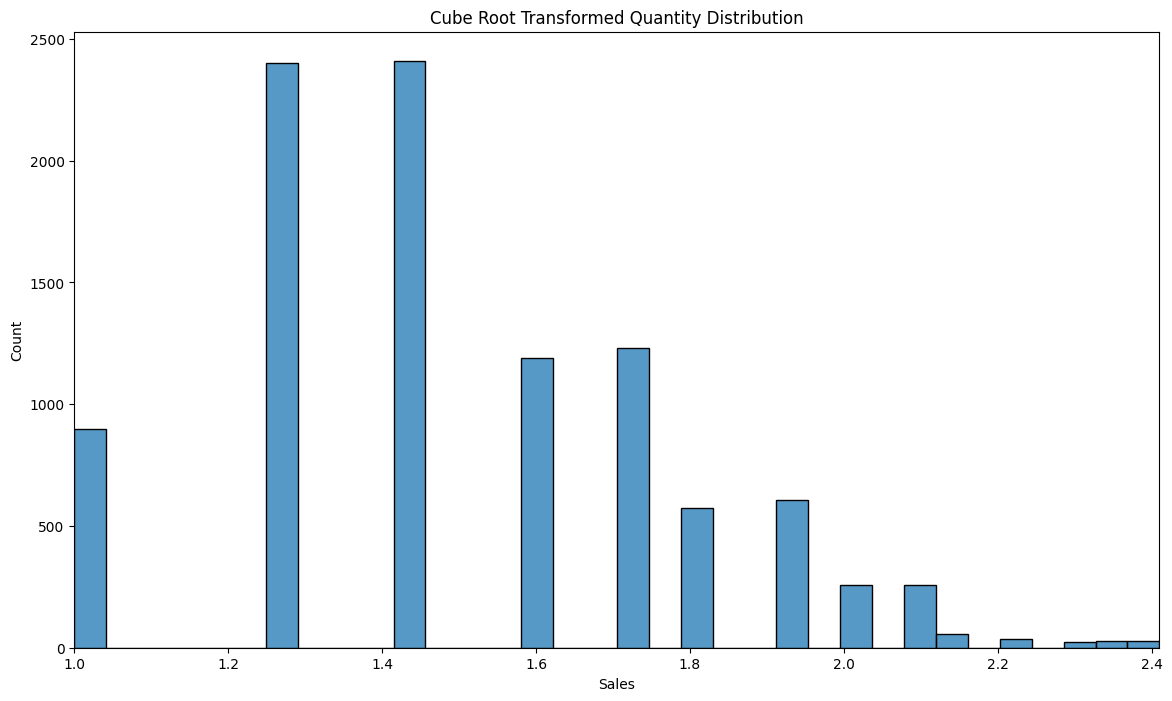

In [73]:
value_to_plot = cube_root_transformed_quantity

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Cube Root Transformed Quantity'

plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

#### Transformed discount distribution

##### Cubic root transformation

In [72]:
cube_root_transformed_discount = np.cbrt(data_cleaned['Discount'])
print("Skewness: %f" % cube_root_transformed_discount.skew())

Skewness: 0.147942


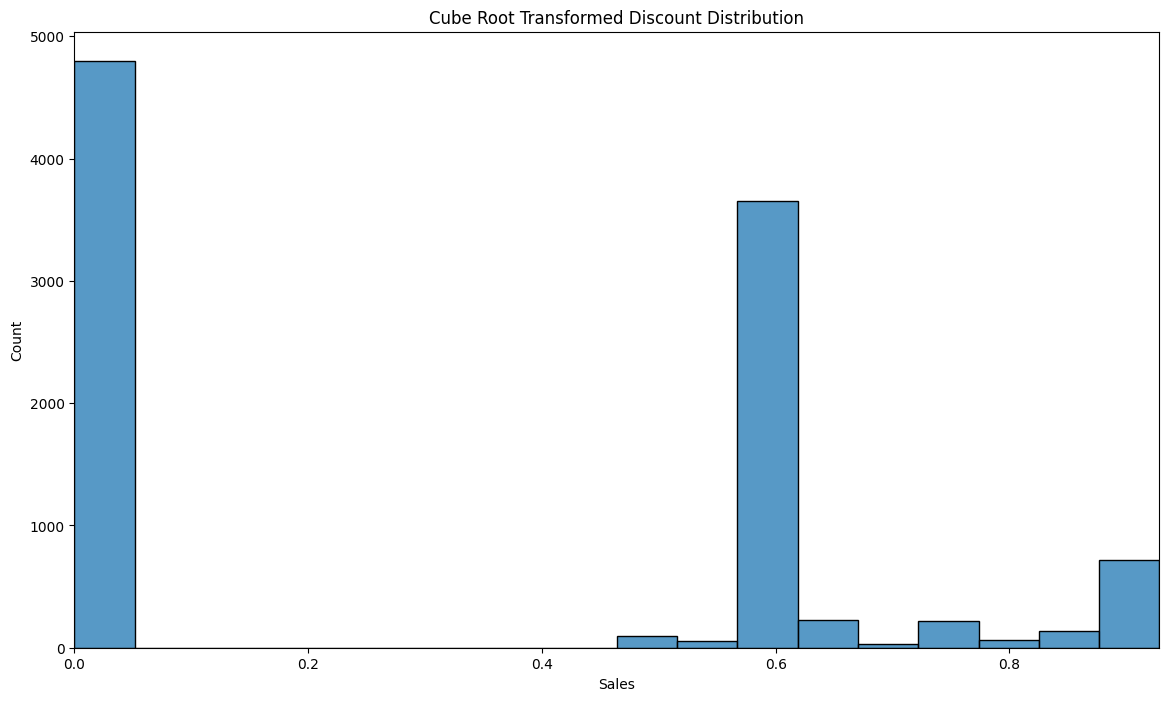

In [74]:
value_to_plot = cube_root_transformed_discount

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Cube Root Transformed Discount'

plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

It looks like we are better off not using any kind of trasformation for the moment, especially for what concerns the profit distribution, and we should isntead focus on dealing with outlayers (if we decide to do so).

## Inspect correlations

First let's analyze any potential correlation between our conitinuous variables. In particular we want to see the relationship of our numerical variables with 'Profit' and 'Sales'.

In [39]:
data_cleaned_num = data_cleaned.select_dtypes(include = ['float64', 'int64'])
data_cleaned_num_corr_profit = data_cleaned_num.corr()['Profit'][:-1] # -1 means that the latest row is the variable we are testing again
top_correlated_features = data_cleaned_num_corr_profit[abs(data_cleaned_num_corr_profit) > 0.1].sort_values(ascending=False) # displays the Pearson Correlation Coefficient greater than the selected trashold
print("There is {} correlated values with Profit:\n{}".format(len(top_correlated_features), top_correlated_features))

There is 2 correlated values with Profit:
Sales       0.479064
Discount   -0.219487
Name: Profit, dtype: float64


<AxesSubplot: >

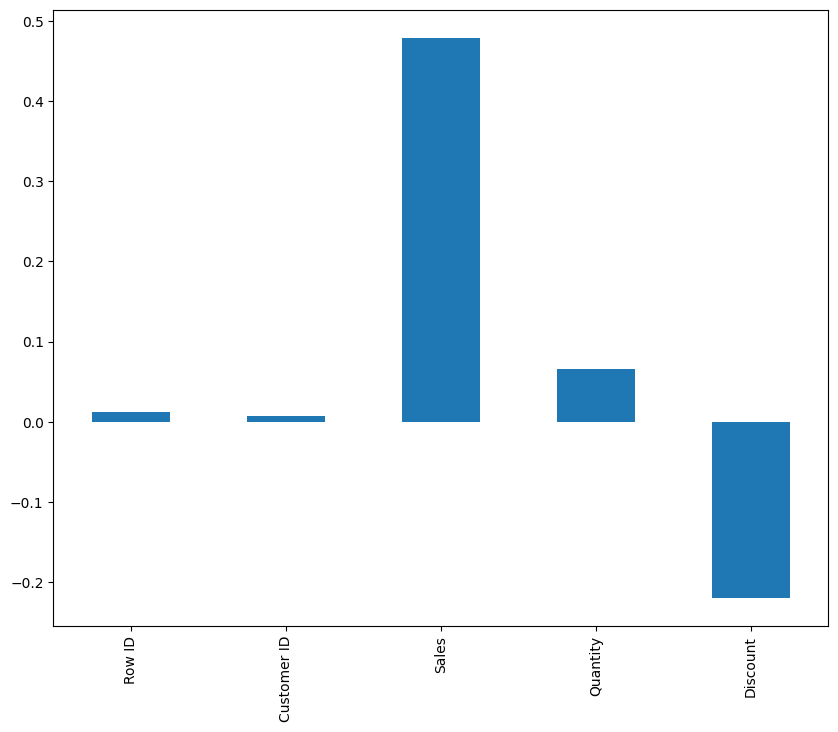

In [40]:
data_cleaned_num_corr_profit.plot(kind="bar",figsize=(10,8))

In [34]:
data_cleaned_num = data_cleaned.select_dtypes(include = ['float64', 'int64'])
data_cleaned_num_corr_sales = data_cleaned_num.corr()['Sales']
top_correlated_features = data_cleaned_num_corr_sales[abs(data_cleaned_num_corr_sales) > 0.1].sort_values(ascending=False) # displays the Pearson Correlation Coefficient greater than the selected trashold
print("There is {} correlated values with Sales:\n{}".format(len(top_correlated_features), top_correlated_features))

There is 3 correlated values with Sales:
Sales       1.000000
Profit      0.479064
Quantity    0.200795
Name: Sales, dtype: float64


<AxesSubplot: >

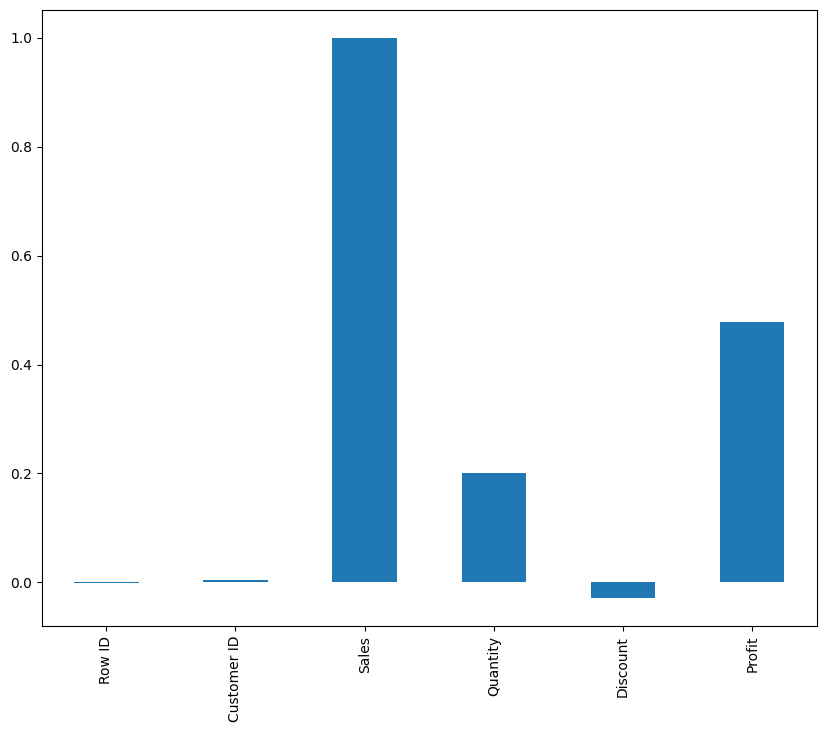

In [35]:
data_cleaned_num_corr_sales.plot(kind="bar",figsize=(10,8))

Now let's plot a correlation matrix to envision the relationships between the data.

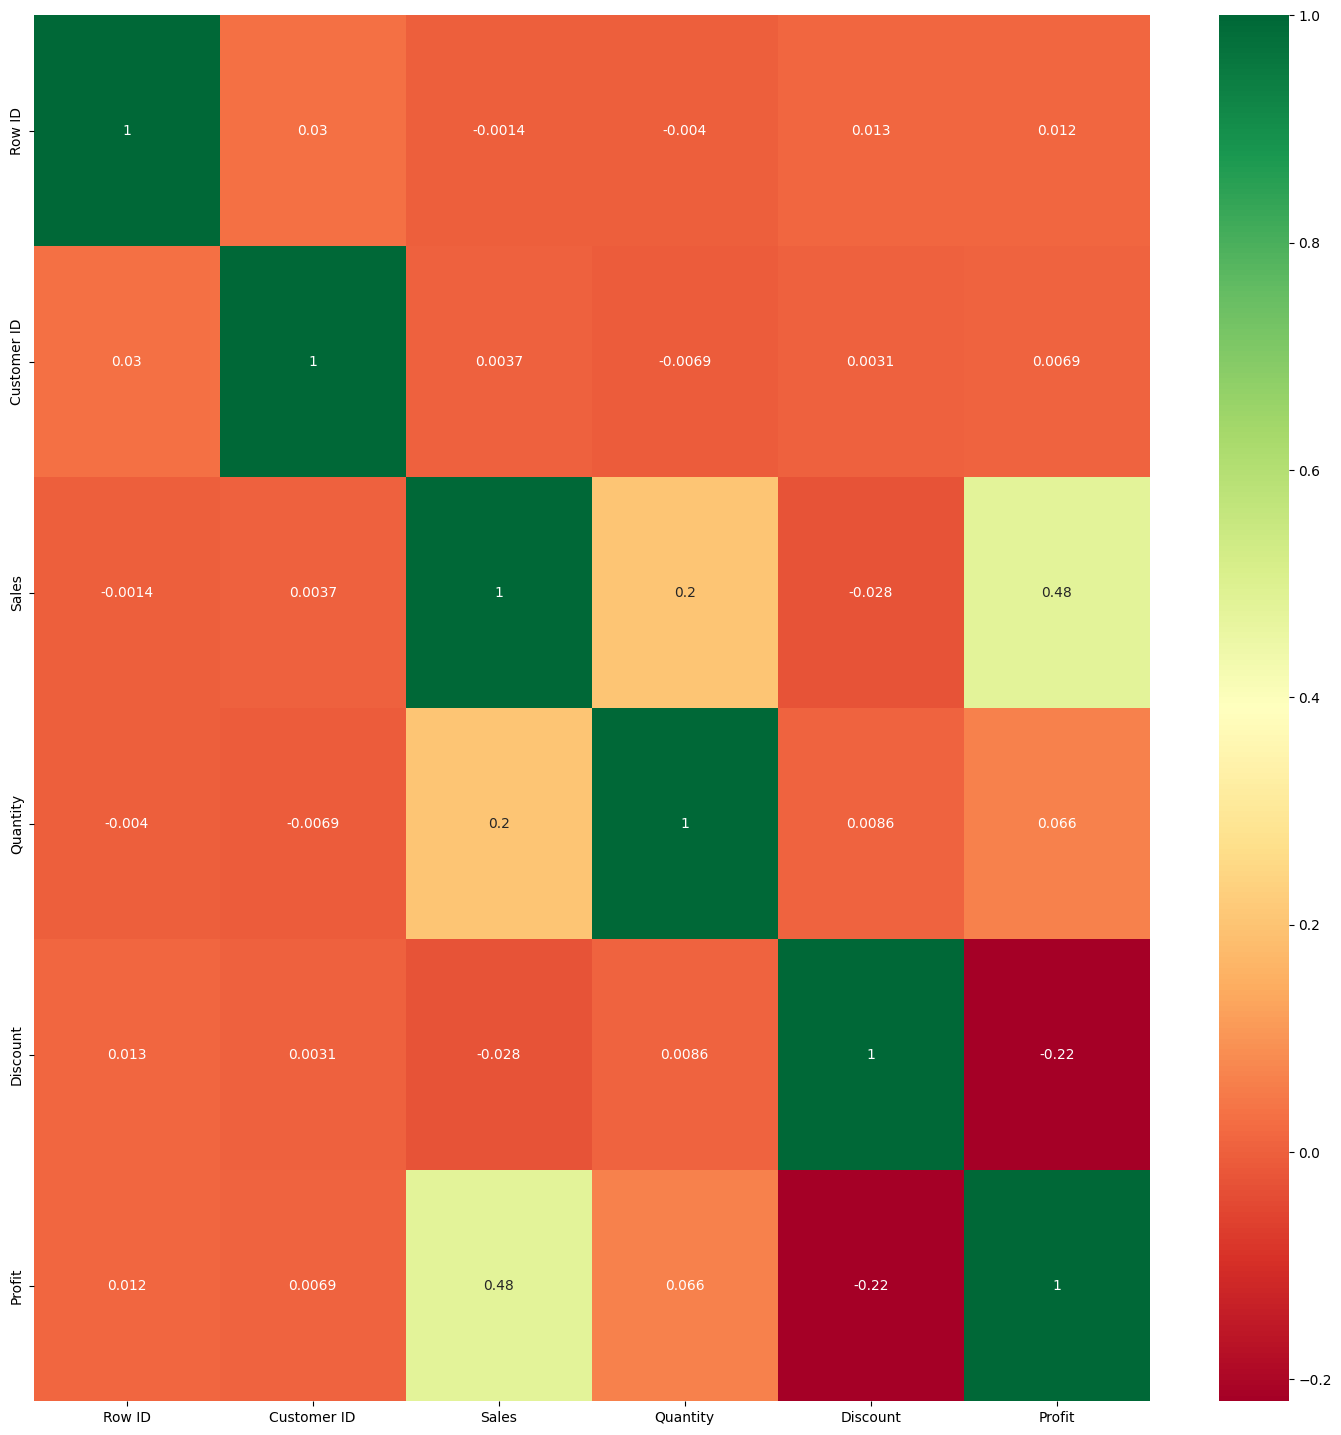

In [16]:
plt.figure(figsize=(18,18))
sns.heatmap(data_cleaned_num.corr(),annot=True,cmap='RdYlGn')
plt.show()

## Reduce outlayers

Let's remove all entries with profit lower -500 and above 500 to see if hels with normalizing the distribution of the data.

In [11]:
data_500 = data_cleaned[(data_cleaned['Profit'] > -500) & (data_cleaned['Profit'] < 500)]
data_500.to_pickle('data_500.pkl')
data_500.describe()

Row ID  Customer ID        Sales     Quantity     Discount  \
count  9827.000000  9827.000000  9827.000000  9827.000000  9827.000000   
mean   4994.553475  1049.784166   182.223709     3.754859     0.155214   
std    2883.241931    29.718520   343.636917     2.203527     0.204769   
min       1.000000  1001.000000     0.444000     1.000000     0.000000   
25%    2497.500000  1024.000000    16.858500     2.000000     0.000000   
50%    4989.000000  1049.000000    51.800000     3.000000     0.200000   
75%    7488.000000  1076.000000   196.728000     5.000000     0.200000   
max    9994.000000  1101.000000  8187.650000    14.000000     0.800000   

            Profit  
count  9827.000000  
mean     21.168176  
std      75.950786  
min    -480.203200  
25%       1.744300  
50%       8.496600  
75%      28.174100  
max     496.786500

### Plot and asses the distribution of the data in the new dataset

#### Sales and Profit distribution

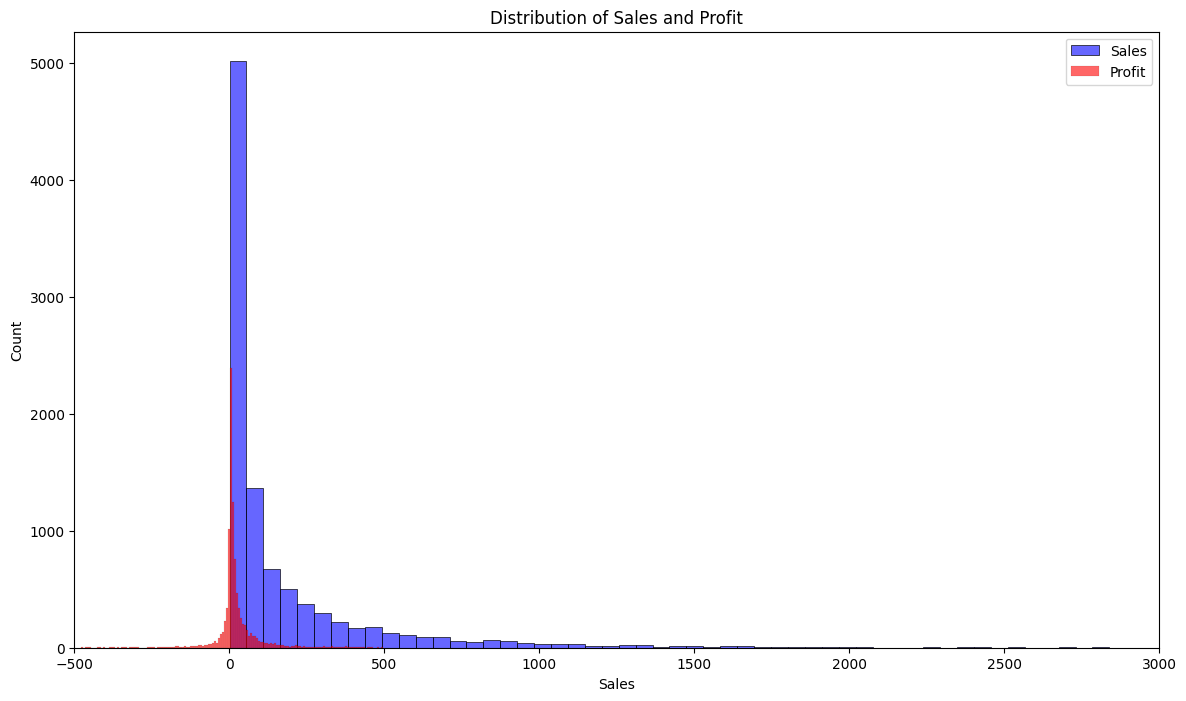

In [13]:
value_to_plot1 = data_500['Sales']
value_to_plot2 = data_500['Profit']

xmin = value_to_plot.min()

#Limit the x-axes to the max number of sales visible by naked eye
xlim = 3000

value_name1 = 'Sales'
value_name2 = 'Profit'

plot_distribution_2(value_to_plot1, value_to_plot2, xmin, xlim, value_name1, value_name2)

Here we can see that the dataset may use some more outlayers removal for sales above 1000 or 1500.

In [14]:
data_500_1000 = data_cleaned[(data_cleaned['Profit'] >= -500) & (data_cleaned['Profit'] <= 500) 
                             & (data_cleaned['Sales'] <= 1000)]
data_500_1000.to_pickle('data_500_1000.pkl')
data_500_1000.describe()

Row ID  Customer ID        Sales     Quantity     Discount  \
count  9509.000000  9509.000000  9509.000000  9509.000000  9509.000000   
mean   5004.550110  1049.779788   136.382930     3.681775     0.156258   
std    2880.939233    29.667245   194.742657     2.153918     0.206819   
min       1.000000  1001.000000     0.444000     1.000000     0.000000   
25%    2515.000000  1024.000000    16.032000     2.000000     0.000000   
50%    4999.000000  1049.000000    47.952000     3.000000     0.200000   
75%    7497.000000  1076.000000   170.352000     5.000000     0.200000   
max    9994.000000  1101.000000   999.980000    14.000000     0.800000   

            Profit  
count  9509.000000  
mean     16.100576  
std      61.167492  
min    -479.988000  
25%       1.684800  
50%       8.046400  
75%      25.098000  
max     449.991000

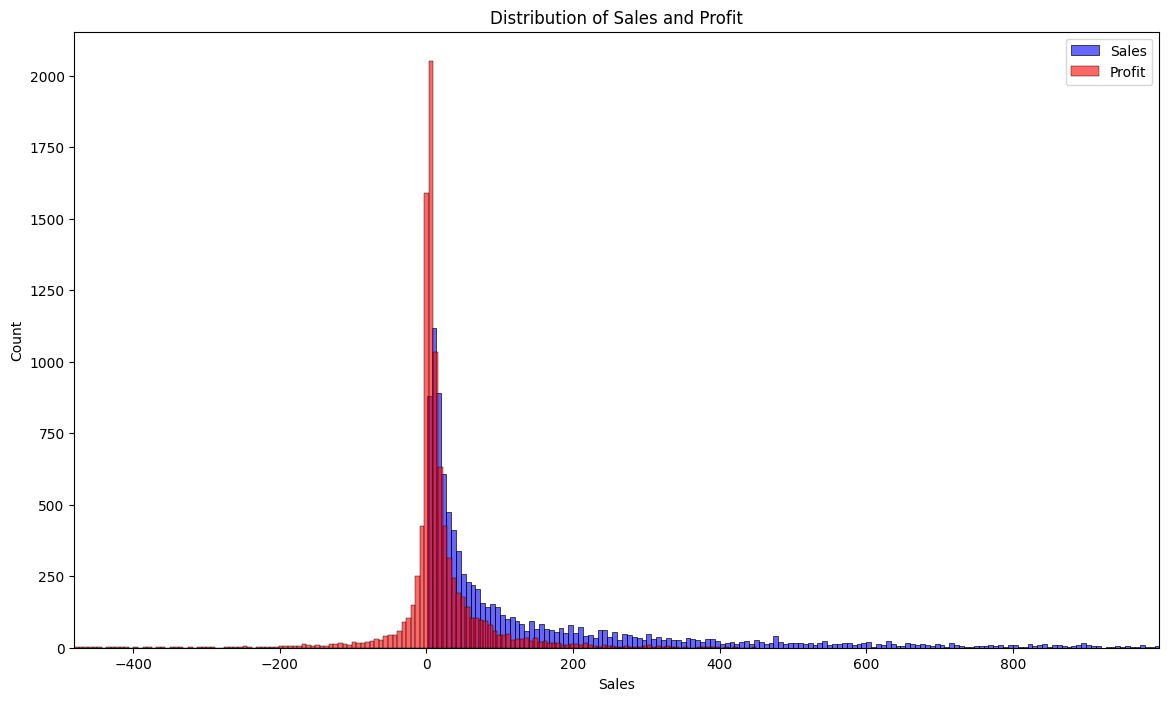

In [16]:
value_to_plot1 = data_500_1000['Sales']
value_to_plot2 = data_500_1000['Profit']

#We are using the min Profit as minimum limit and the Sales max as the maximum as profits are lower than sales.
xmin = value_to_plot2.min()
xlim = value_to_plot1.max()

value_name1 = 'Sales'
value_name2 = 'Profit'

plot_distribution_2(value_to_plot1, value_to_plot2, xmin, xlim, value_name1, value_name2)

#### Sales distribution

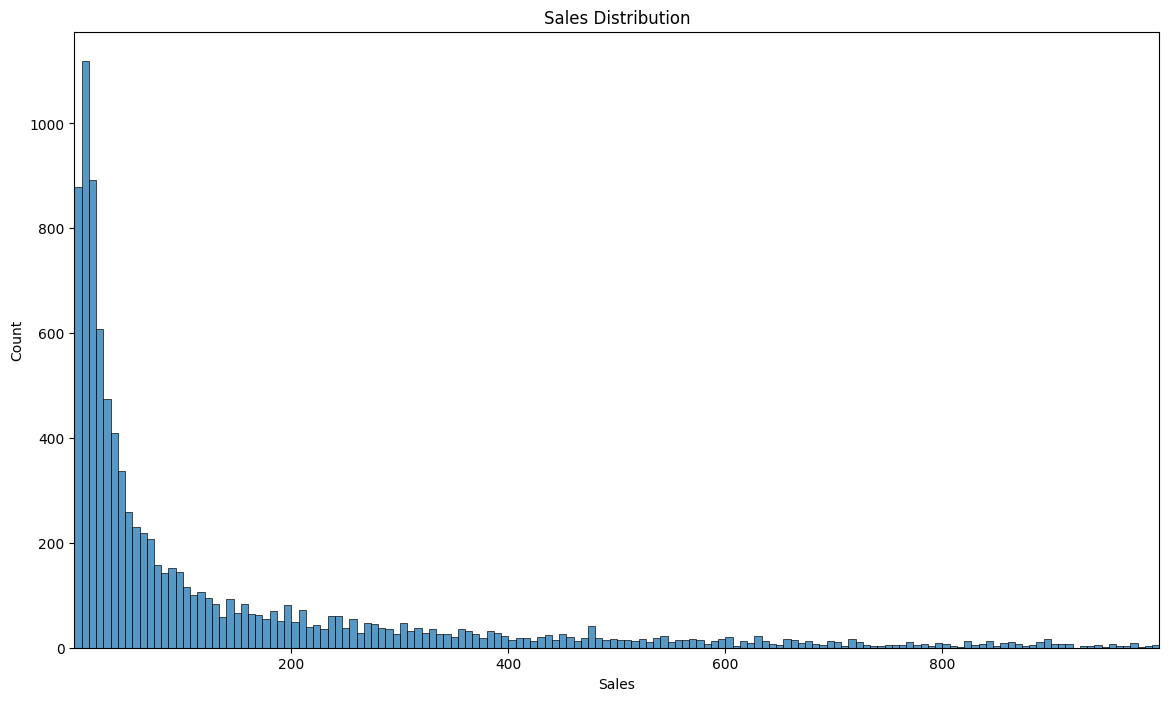

In [17]:
value_to_plot = data_500_1000['Sales']

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Sales'

plot_distribution(value_to_plot,xmin, xlim,value_name)

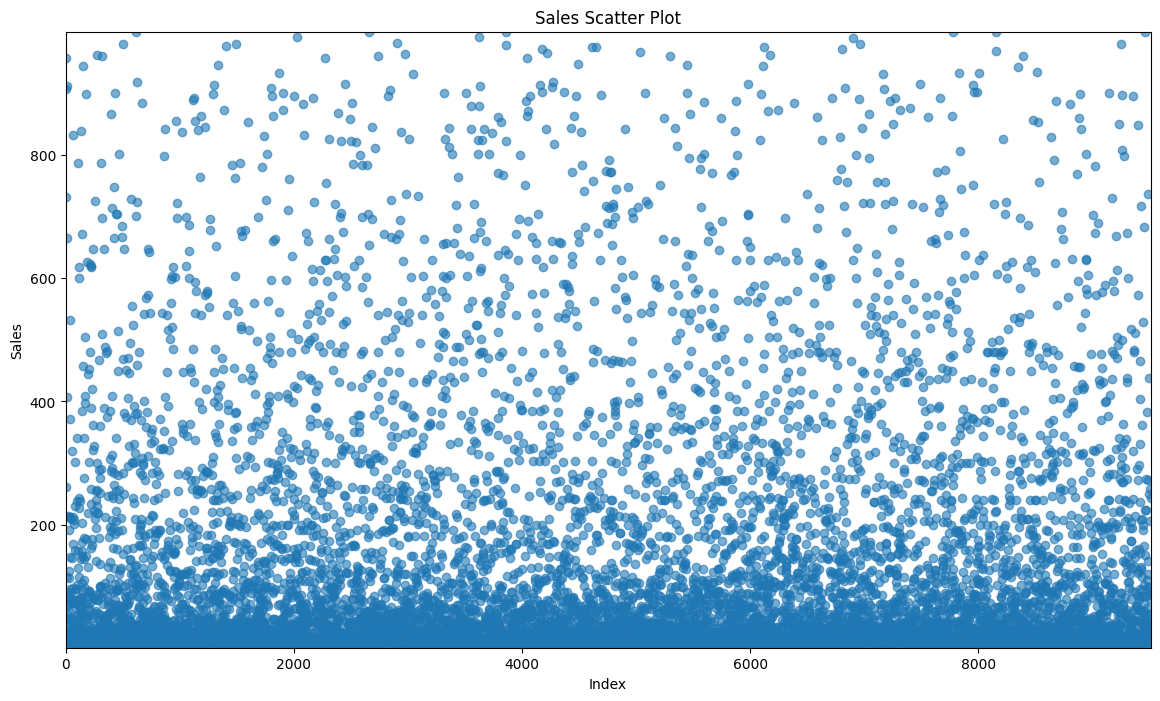

In [18]:
value_to_plot = data_500_1000['Sales']

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Sales'

plot_scatter(value_to_plot, xmin, xlim, value_name)

We can see that most deals are below 200-150, so they have much lower profits. For the moment, we are not removing any more data, but if we wanted to make a strong linear regression model, we could remove all deals above 200 to predict the most likely deal.

<AxesSubplot: xlabel='Sales'>

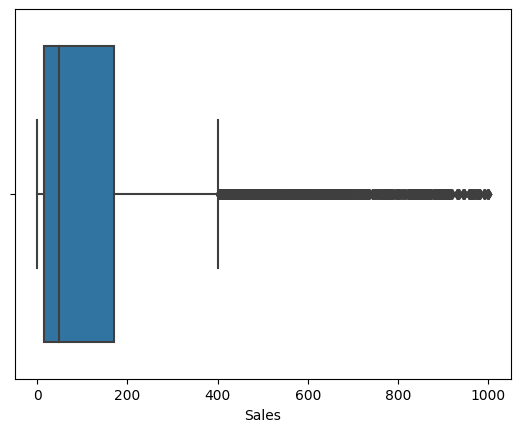

In [35]:
sns.boxplot(x=data_500_1000['Sales'])

In [19]:
print("Skewness: %f" % data_500_1000['Sales'].skew())

Skewness: 2.146240


In [39]:
filtered_data2 = data_cleaned[data_cleaned['Sales'] < 200]['Sales']

<AxesSubplot: xlabel='Sales'>

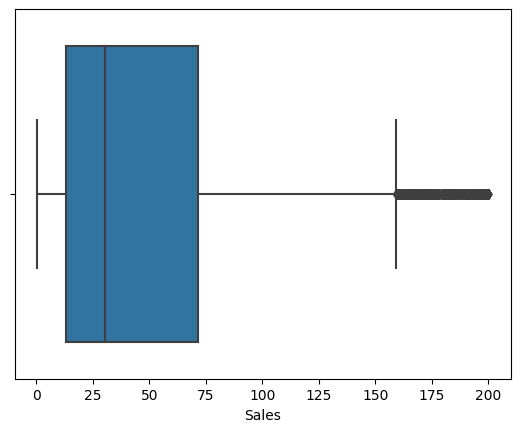

In [40]:
sns.boxplot(x=filtered_data2)

As we can see from the box plot, we still have outlayers.

In [41]:
print("Skewness: %f" % filtered_data2.skew())

Skewness: 1.329624


Even by selecting only sales below 200, we still don't have a normal distribution. But that's okay, because in sales, most leads will not make any sales, and bigger deals are more rare. So, the distribution follows a realistic pattern. The only worrying aspect, is that small deals often result in a loss of profit, and this is caused by a misalignement of the sales and finance goals, and a better pricing strategy should also be implemented.

#### Profit distribution

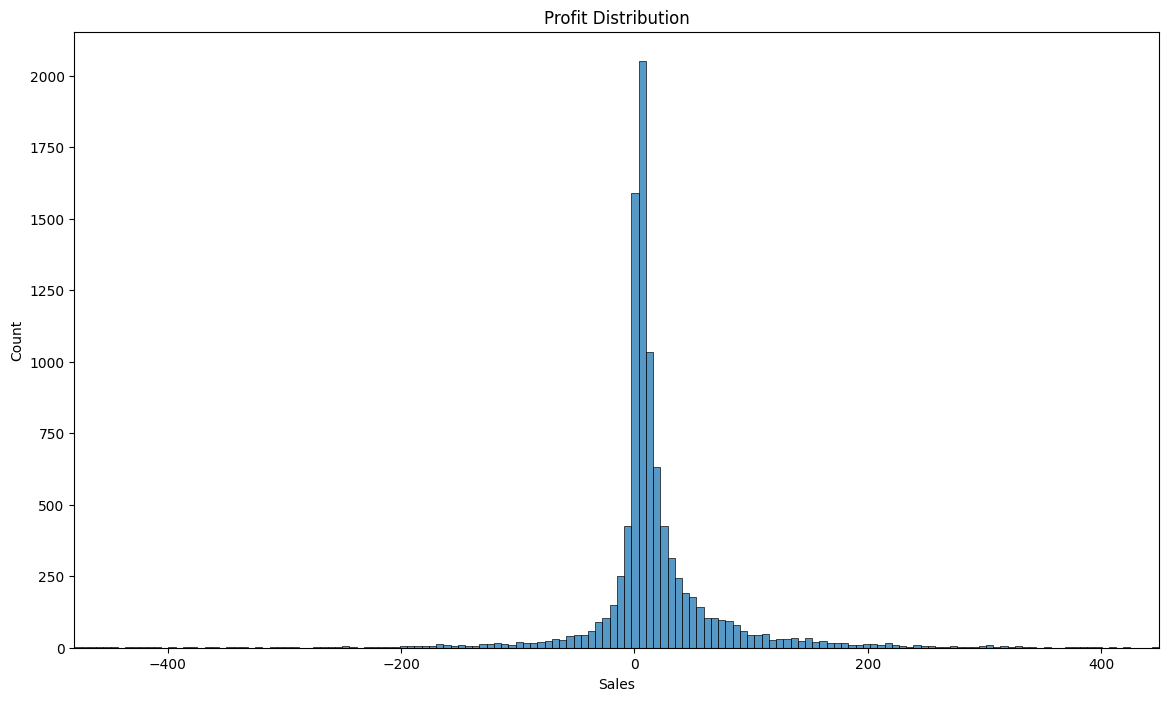

In [26]:
value_to_plot = data_500_1000['Profit']

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Profit'

plot_distribution(value_to_plot,xmin, xlim,value_name)

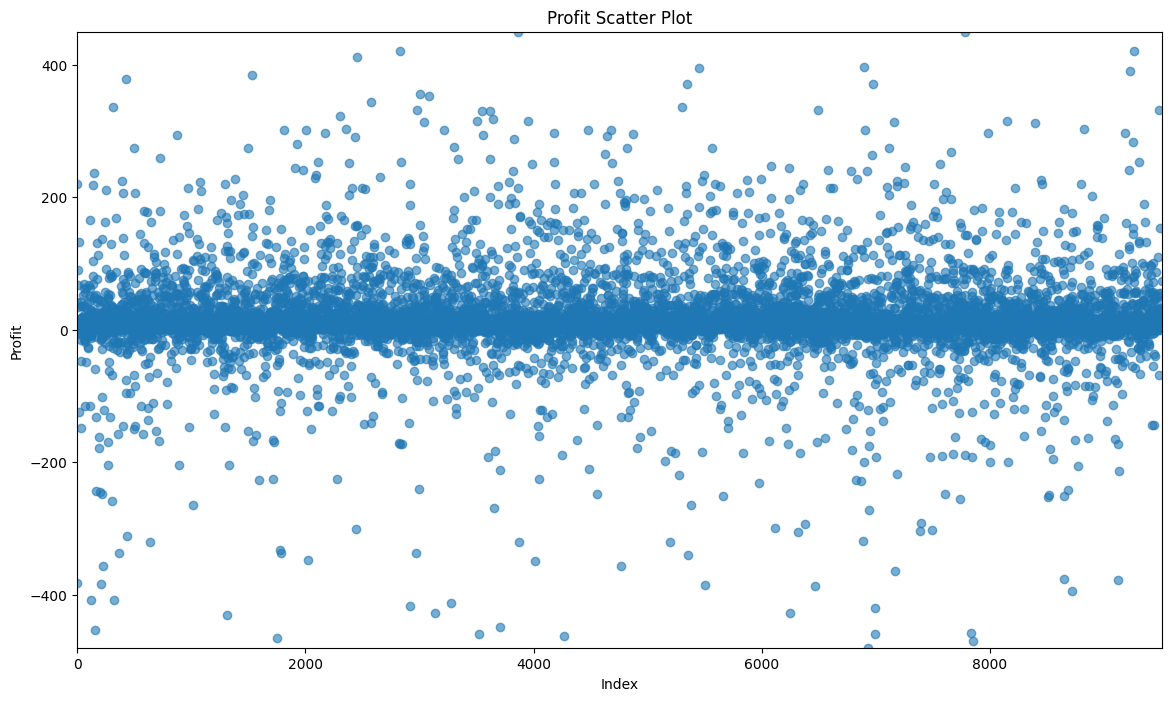

In [27]:
value_to_plot = data_500_1000['Profit']

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Profit'

plot_scatter(value_to_plot, xmin, xlim, value_name)

<AxesSubplot: xlabel='Profit'>

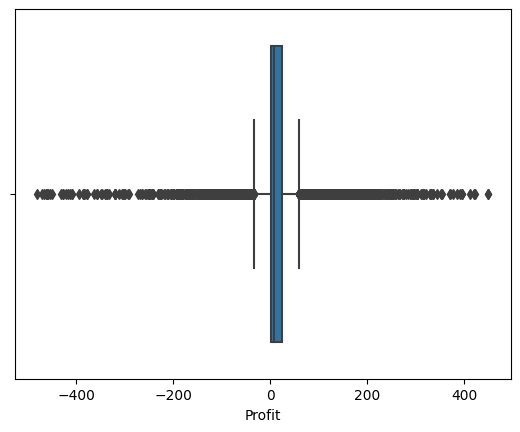

In [42]:
sns.boxplot(x=data_500_1000['Profit'])

It looks like we have many outlayers, but the fact that the majority of leads result in a no-deal situation, is making the middle of the data distribution very prononunced. However, we cannot simply remove the no-deals situations, because otherwise any prediction wouldn't be realistic.

On the bright side, we can see that profitable deals happen more frequently that non-profitable deals.

In [28]:
print("Skewness: %f" % data_500_1000['Profit'].skew())

Skewness: -0.345508


We can see that our target variable, "Profit", is normally distributed, and therefore, it would be easier to predict through linear regression, if we needed to.

#### Quantity distribution

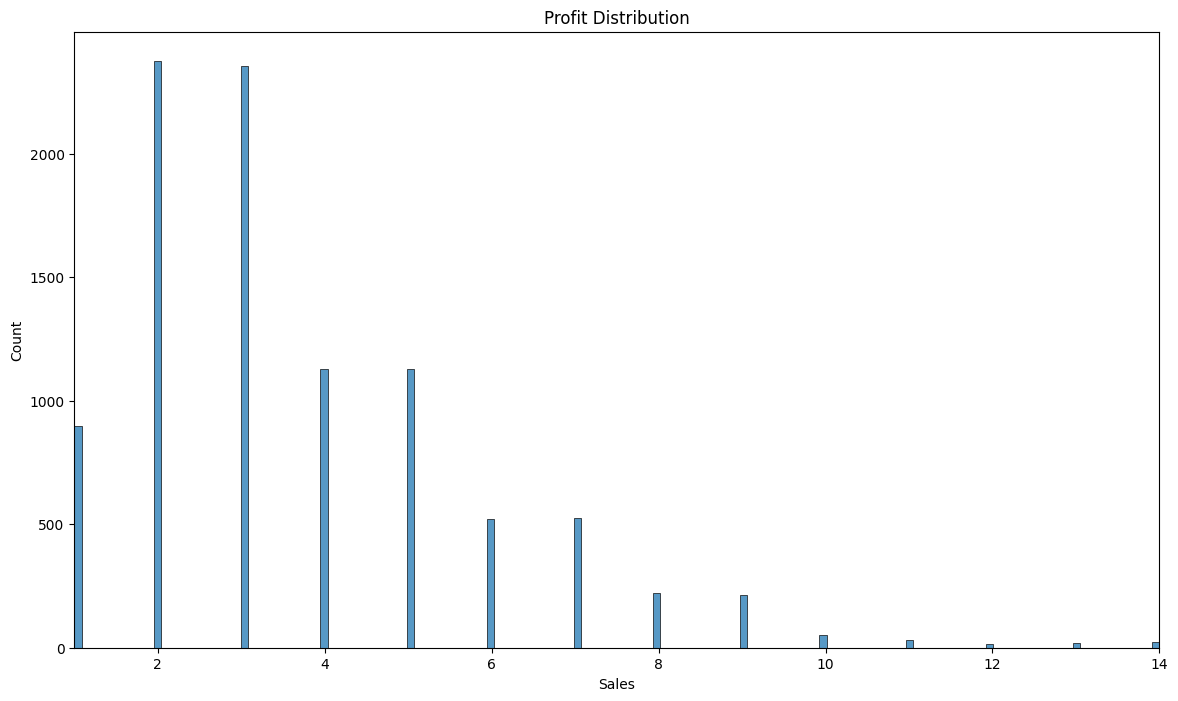

In [29]:
value_to_plot = data_500_1000['Quantity']

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Profit'

plot_distribution(value_to_plot,xmin, xlim,value_name)

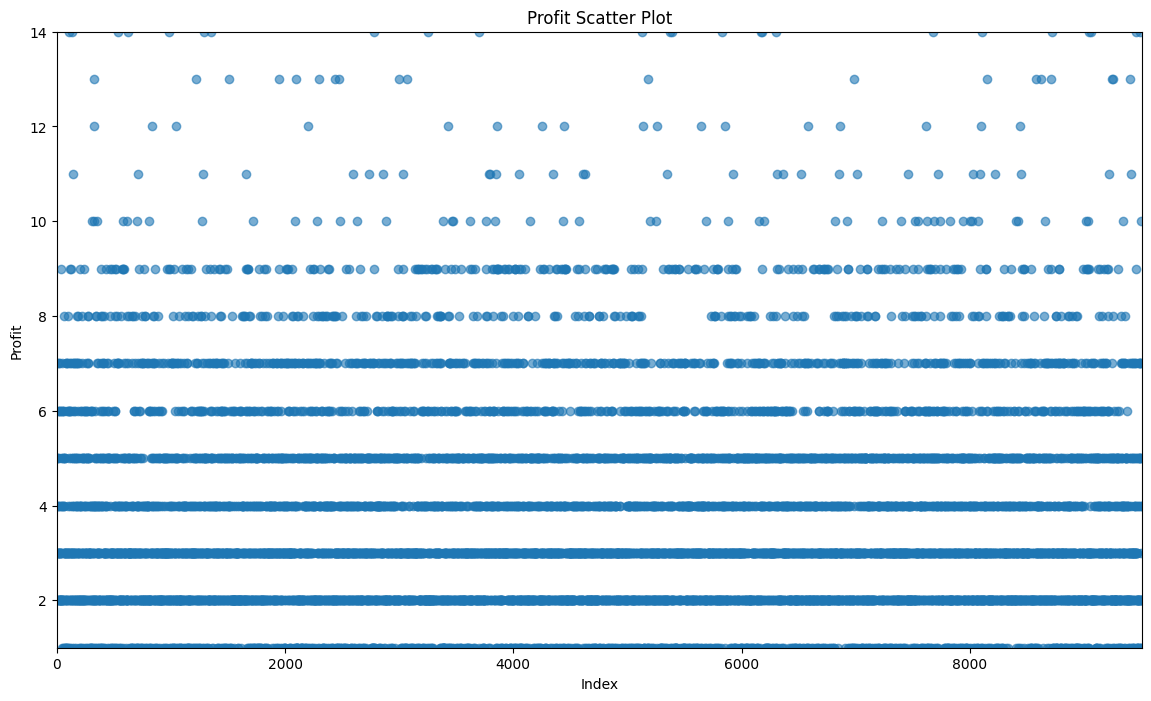

In [30]:
value_to_plot = data_500_1000['Quantity']

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Profit'

plot_scatter(value_to_plot, xmin, xlim, value_name)

<AxesSubplot: xlabel='Quantity'>

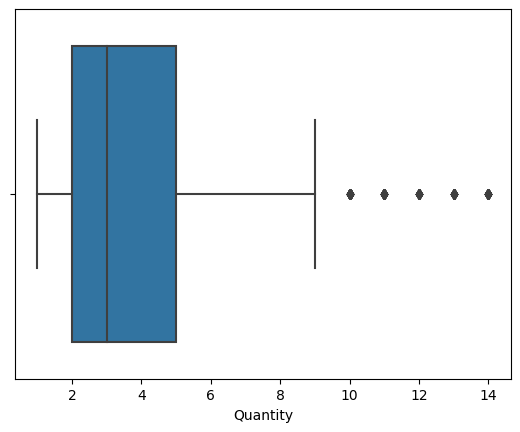

In [43]:
sns.boxplot(x=data_500_1000['Quantity'])

In [31]:
print("Skewness: %f" % data_500_1000['Quantity'].skew())

Skewness: 1.315907


There was very little change to the quantity distribution of the deals. Indeed, we removed very infrequent deals from the dataset, and they did not use to influence the rest of the data very much.

#### Discount distribution

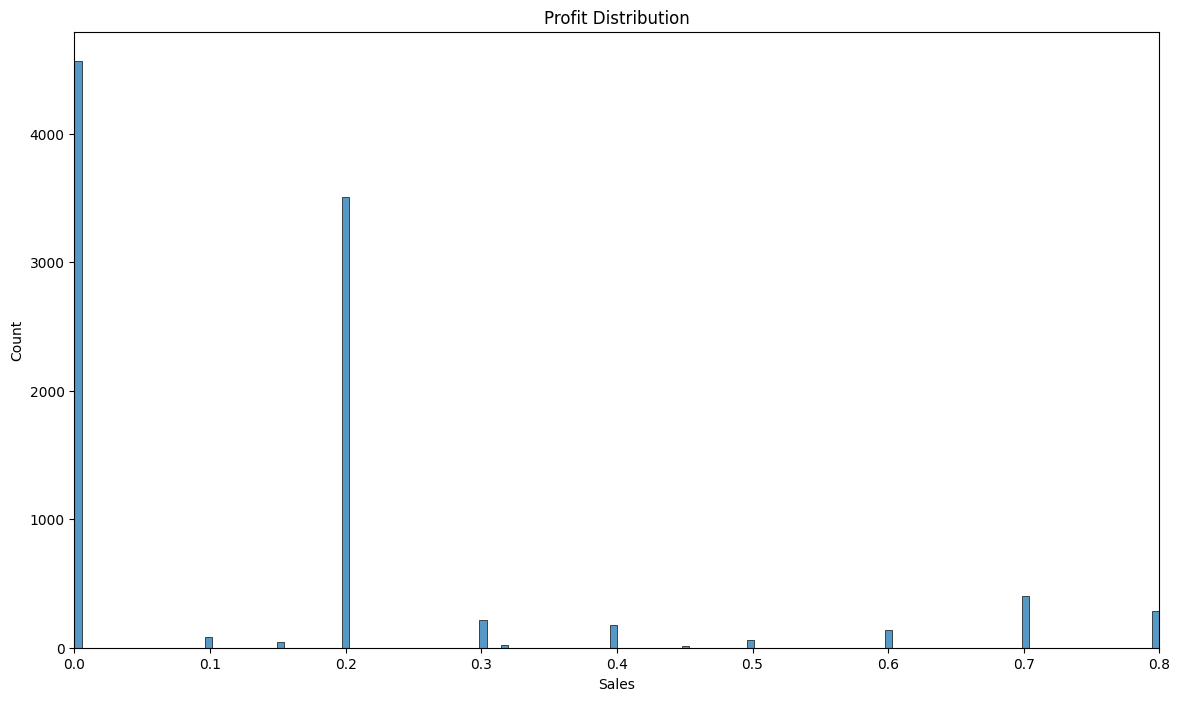

In [32]:
value_to_plot = data_500_1000['Discount']

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Profit'

plot_distribution(value_to_plot,xmin, xlim,value_name)

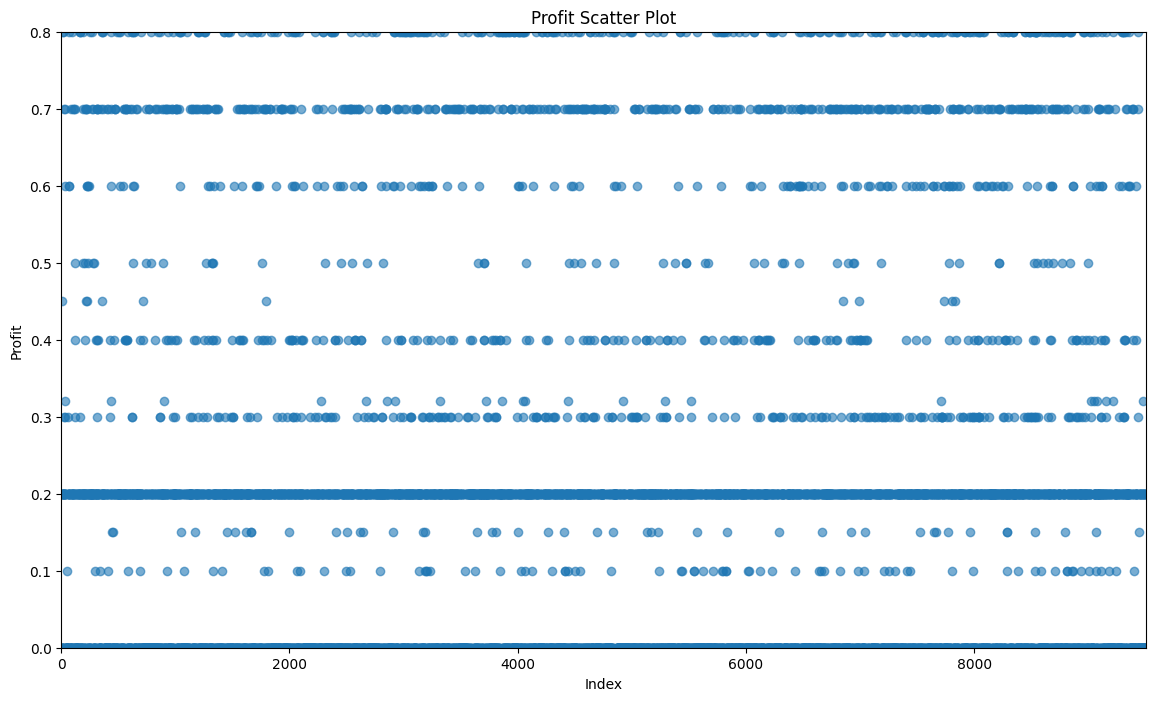

In [33]:
value_to_plot = data_500_1000['Discount']

xmin = value_to_plot.min()
xlim = value_to_plot.max()

value_name = 'Profit'

plot_scatter(value_to_plot, xmin, xlim, value_name)

<AxesSubplot: xlabel='Discount'>

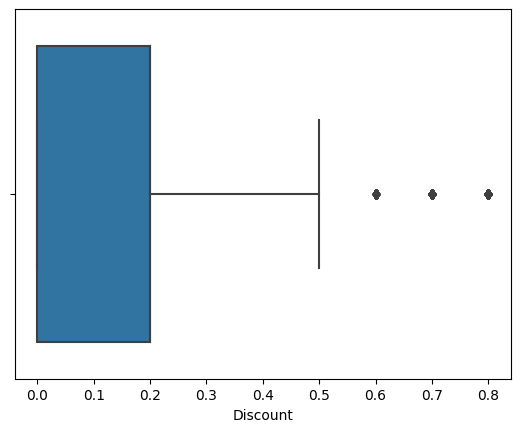

In [44]:
sns.boxplot(x=data_500_1000['Discount'])

In [34]:
print("Skewness: %f" % data_500_1000['Discount'].skew())

Skewness: 1.689595


The same apllies even more to the distribution of the discounts. Probably little discount was applied to very small deals or very big deals, or simply those deals were not frequent enough.

Before hading to encoding our categorical variables, let's check for linearity in our continuous variables.

<AxesSubplot: xlabel='Quantity', ylabel='Profit'>

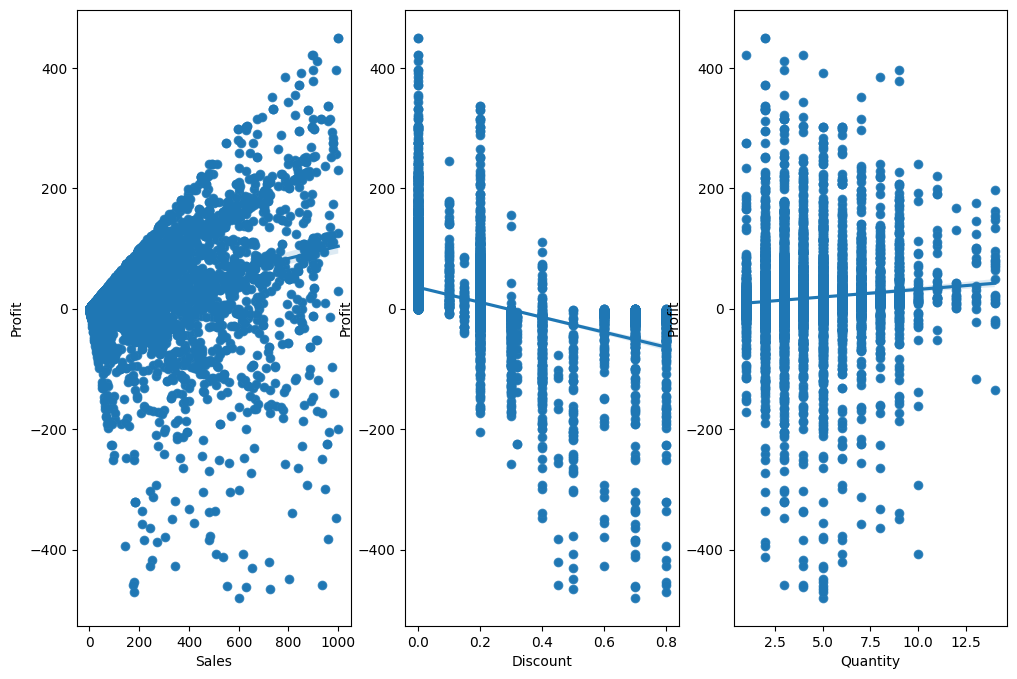

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12,8), ncols=3,sharey=False)
sns.scatterplot( x = data_500_1000.Sales, y = data_500_1000.Profit,  ax=ax1)
sns.regplot(x=data_500_1000.Sales, y=data_500_1000.Profit, ax=ax1)
sns.scatterplot( x = data_500_1000.Discount, y = data_500_1000.Profit,  ax=ax2)
sns.regplot(x=data_500_1000.Discount, y=data_500_1000.Profit, ax=ax2)
sns.scatterplot( x = data_500_1000.Quantity, y = data_500_1000.Profit,  ax=ax3)
sns.regplot(x=data_500_1000.Quantity, y=data_500_1000.Profit, ax=ax3)

<AxesSubplot: xlabel='Quantity', ylabel='Sales'>

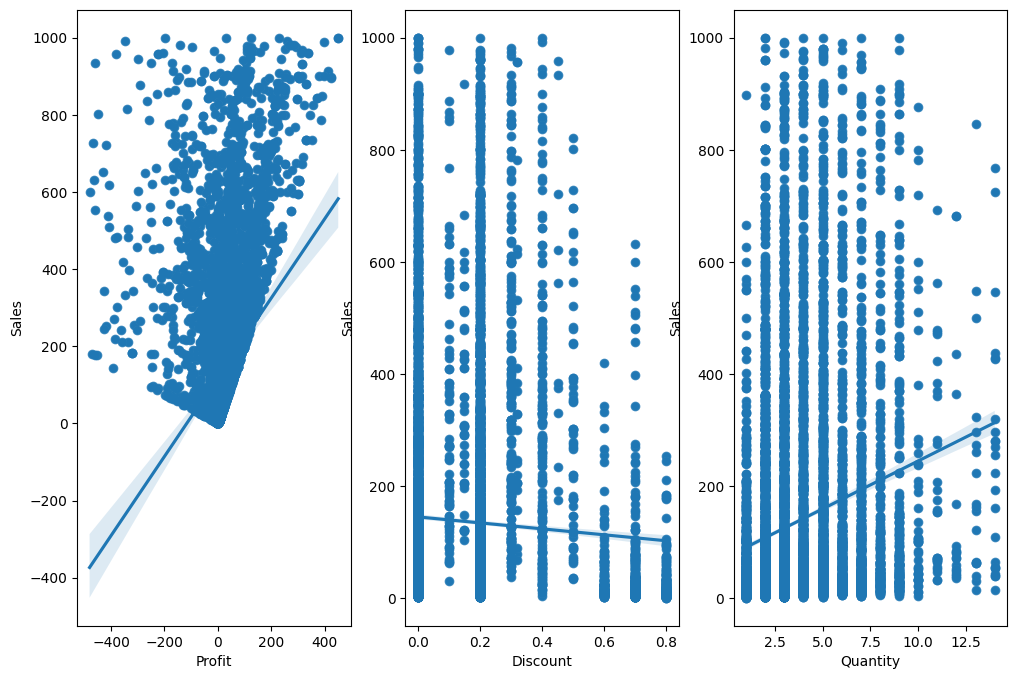

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12,8), ncols=3,sharey=False)
sns.scatterplot( x = data_500_1000.Profit, y = data_500_1000.Sales,  ax=ax1)
sns.regplot(x=data_500_1000.Profit, y=data_500_1000.Sales, ax=ax1)
sns.scatterplot( x = data_500_1000.Discount, y = data_500_1000.Sales,  ax=ax2)
sns.regplot(x=data_500_1000.Discount, y=data_500_1000.Sales, ax=ax2)
sns.scatterplot( x = data_500_1000.Quantity, y = data_500_1000.Sales,  ax=ax3)
sns.regplot(x=data_500_1000.Quantity, y=data_500_1000.Sales, ax=ax3)

There is not much linearity between Sales and the other variables, but Profit is doing a bit better with linearity.

## Encode non-numerical variables

Now that we dealt with reducing outlayers, we want to encode some of the categorical variables to see if and how they influence Profit (e.g., more or less profitable locations, clients, etc).

In [45]:
data_500_1000.columns

Index(['Row ID', 'Order ID', 'Contact Name', 'Country', 'City', 'Region',
       'Subregion', 'Customer', 'Customer ID', 'Industry', 'Segment',
       'Product', 'License', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Order Date Datetime'],
      dtype='object')

In [46]:
#We shall create a new dataset and use one-hot encoding to transform categorical variables.
data_encoded = pd.get_dummies(data_500_1000, columns=['Contact Name', 'Country','City','Region','Subregion',
                                                       'Customer',
                                                       'Industry', 'Segment',
       'Product', 'License',], drop_first=True, dtype="int64")
data_encoded.head()

Row ID          Order ID  Customer ID     Sales  Quantity  Discount  \
0       1  EMEA-2022-152156         1017  261.9600         2      0.00   
1       2  EMEA-2022-152156         1017  731.9400         3      0.00   
2       3  AMER-2022-138688         1056   14.6200         2      0.00   
3       4  EMEA-2021-108966         1031  957.5775         5      0.45   
4       5  EMEA-2021-108966         1031   22.3680         2      0.20   

     Profit Order Date Datetime  Contact Name_Adam Davidson  \
0   41.9136          2022-11-09                           0   
1  219.5820          2022-11-09                           0   
2    6.8714          2022-06-13                           0   
3 -383.0310          2021-10-11                           0   
4    2.5164          2021-10-11                           0   

   Contact Name_Adam James  ...  License_ZYL9KDTY68  License_ZYRN6KZJ3V  \
0                        0  ...                   0                   0   
1                        0  ...                   0                   0   
2                        0  ...                   0                   0   
3                        0  ...                   0                   0   
4                        0  ...                   0                   0   

   License_ZYSJLIH6VE  License_ZZBS1SYVGD  License_ZZC5WEGC6D  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   License_ZZGIFGODFG  License_ZZJ576721E  License_ZZMTLCNNWQ  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   License_ZZU7U59ZX9  License_ZZYPG83FN9  
0                   0                   0  
1                   0                   0  
2                   0                   0  
3                   0                   0  
4                   0                   0  

[5 rows x 10749 columns]

In [47]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9509 entries, 0 to 9993
Columns: 10749 entries, Row ID to License_ZZYPG83FN9
dtypes: datetime64[ns](1), float64(3), int64(10744), object(1)
memory usage: 779.9+ MB


As we can see, there are too many variables now, so let's drop some of the columns.

In [48]:
data_encoded2 = pd.get_dummies(data_500_1000, columns=['Country', 'Customer', 'Industry', 'Segment',
       'Product', 'License',], drop_first=True, dtype="int64")
data_encoded2.head()

Row ID          Order ID    Contact Name           City Region Subregion  \
0       1  EMEA-2022-152156     Nathan Bell         Dublin   EMEA      UKIR   
1       2  EMEA-2022-152156     Nathan Bell         Dublin   EMEA      UKIR   
2       3  AMER-2022-138688  Deirdre Bailey  New York City   AMER     NAMER   
3       4  EMEA-2021-108966      Zoe Hodges      Stuttgart   EMEA   EU-WEST   
4       5  EMEA-2021-108966      Zoe Hodges      Stuttgart   EMEA   EU-WEST   

   Customer ID     Sales  Quantity  Discount  ...  License_ZYL9KDTY68  \
0         1017  261.9600         2      0.00  ...                   0   
1         1017  731.9400         3      0.00  ...                   0   
2         1056   14.6200         2      0.00  ...                   0   
3         1031  957.5775         5      0.45  ...                   0   
4         1031   22.3680         2      0.20  ...                   0   

  License_ZYRN6KZJ3V  License_ZYSJLIH6VE  License_ZZBS1SYVGD  \
0                  0                   0                   0   
1                  0                   0                   0   
2                  0                   0                   0   
3                  0                   0                   0   
4                  0                   0                   0   

   License_ZZC5WEGC6D  License_ZZGIFGODFG  License_ZZJ576721E  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   License_ZZMTLCNNWQ  License_ZZU7U59ZX9  License_ZZYPG83FN9  
0                   0                   0                   0  
1                   0                   0                   0  
2                   0                   0                   0  
3                   0                   0                   0  
4                   0                   0                   0  

[5 rows x 9688 columns]

In [49]:
data_encoded2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9509 entries, 0 to 9993
Columns: 9688 entries, Row ID to License_ZZYPG83FN9
dtypes: datetime64[ns](1), float64(3), int64(9679), object(5)
memory usage: 702.9+ MB


The "Country" and "Customer" variables could be quite insightful, but there are too many of them. Future analysis could slice the data to tackle only the most and least profitable customers and countries, but for now, we will have to remove them.

In [53]:
data_encoded3 = pd.get_dummies(data_500_1000, columns=['Industry', 'Segment',
       'Product'], drop_first=True, dtype="int64")
data_encoded3.head()

Row ID          Order ID    Contact Name        Country           City  \
0       1  EMEA-2022-152156     Nathan Bell        Ireland         Dublin   
1       2  EMEA-2022-152156     Nathan Bell        Ireland         Dublin   
2       3  AMER-2022-138688  Deirdre Bailey  United States  New York City   
3       4  EMEA-2021-108966      Zoe Hodges        Germany      Stuttgart   
4       5  EMEA-2021-108966      Zoe Hodges        Germany      Stuttgart   

  Region Subregion           Customer  Customer ID     License  ...  \
0   EMEA      UKIR            Chevron         1017  16GRM07R1K  ...   
1   EMEA      UKIR            Chevron         1017  QLIW57KZUV  ...   
2   AMER     NAMER        Phillips 66         1056  JI6BVL70HQ  ...   
3   EMEA   EU-WEST  Royal Dutch Shell         1031  DE9GJKGD44  ...   
4   EMEA   EU-WEST  Royal Dutch Shell         1031  OIF7NY23WD  ...   

   Product_Data Smasher  Product_FinanceHub  Product_Marketing Suite  \
0                     0                   0                        1   
1                     0                   1                        0   
2                     0                   1                        0   
3                     0                   0                        0   
4                     0                   0                        0   

   Product_Marketing Suite - Gold Product_OneView  \
0                               0               0   
1                               0               0   
2                               0               0   
3                               0               0   
4                               1               0   

   Product_SaaS Connector Pack  Product_SaaS Connector Pack - Gold  \
0                            0                                   0   
1                            0                                   0   
2                            0                                   0   
3                            0                                   0   
4                            0                                   0   

   Product_Site Analytics  Product_Storage  Product_Support  
0                       0                0                0  
1                       0                0                0  
2                       0                0                0  
3                       0                0                0  
4                       0                0                0  

[5 rows x 39 columns]

In [54]:
data_encoded3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9509 entries, 0 to 9993
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Row ID                              9509 non-null   int64         
 1   Order ID                            9509 non-null   object        
 2   Contact Name                        9509 non-null   object        
 3   Country                             9509 non-null   object        
 4   City                                9509 non-null   object        
 5   Region                              9509 non-null   object        
 6   Subregion                           9509 non-null   object        
 7   Customer                            9509 non-null   object        
 8   Customer ID                         9509 non-null   int64         
 9   License                             9509 non-null   object        
 10  Sales                   

Now we have a managiable amount of variables, and "Product", "Industry", and "Segment", could be quite insightful as well.

Now let's check if we have any correlation with our dependent variable "Profit".

In [57]:
data_encoded_num = data_encoded3.select_dtypes(include = ['float64', 'int64'])
data_encoded_num_corr_profit = data_encoded_num.corr()['Profit']
top_correlated_features_data_encoded = data_encoded_num_corr_profit[abs(data_encoded_num_corr_profit) > 0.05].sort_values(ascending=False) # displays the Pearson Correlation Coefficient greater than the selected trashold
print("There is {} correlated values with Profit:\n{}".format(len(top_correlated_features_data_encoded), top_correlated_features_data_encoded))

There is 8 correlated values with Profit:
Profit                     1.000000
Sales                      0.322919
Product_Data Smasher       0.106140
Product_Site Analytics     0.092054
Quantity                   0.089064
Product_Marketing Suite   -0.095121
Product_ContactMatcher    -0.134186
Discount                  -0.420496
Name: Profit, dtype: float64


There are some positive weak correlations between product category and profitability (i.e., data smasher, site analytics), and some negative weak correlations (i.e., marketing suite, contact matcher).

<AxesSubplot: >

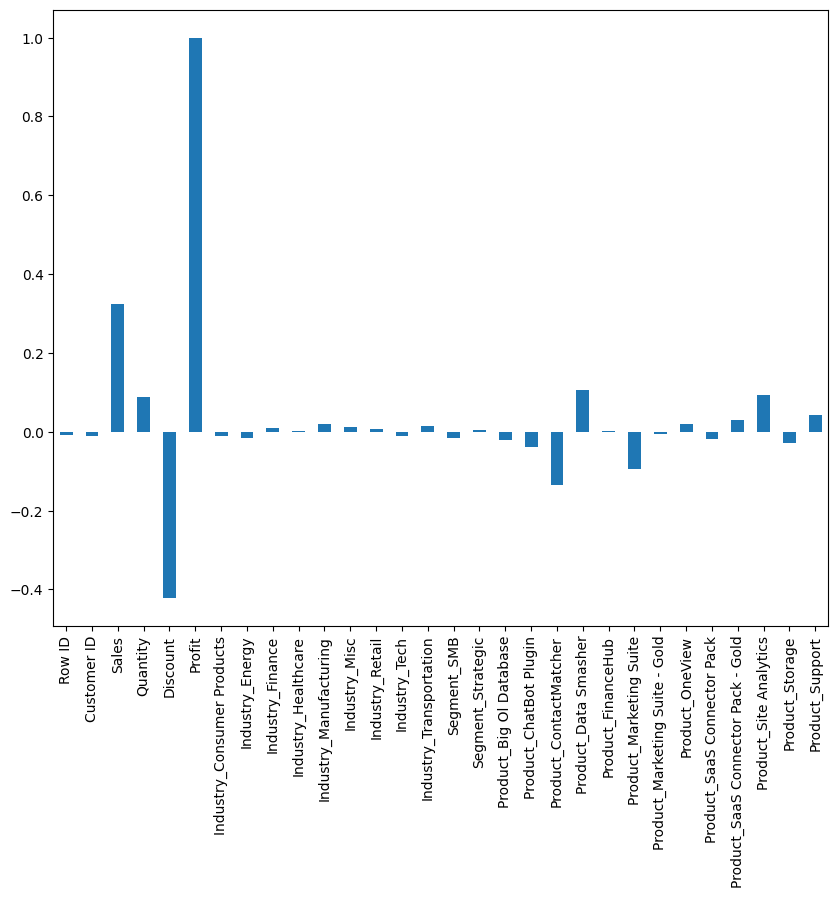

In [61]:
data_encoded_num_corr_profit.plot(kind="bar",figsize=(10,8))

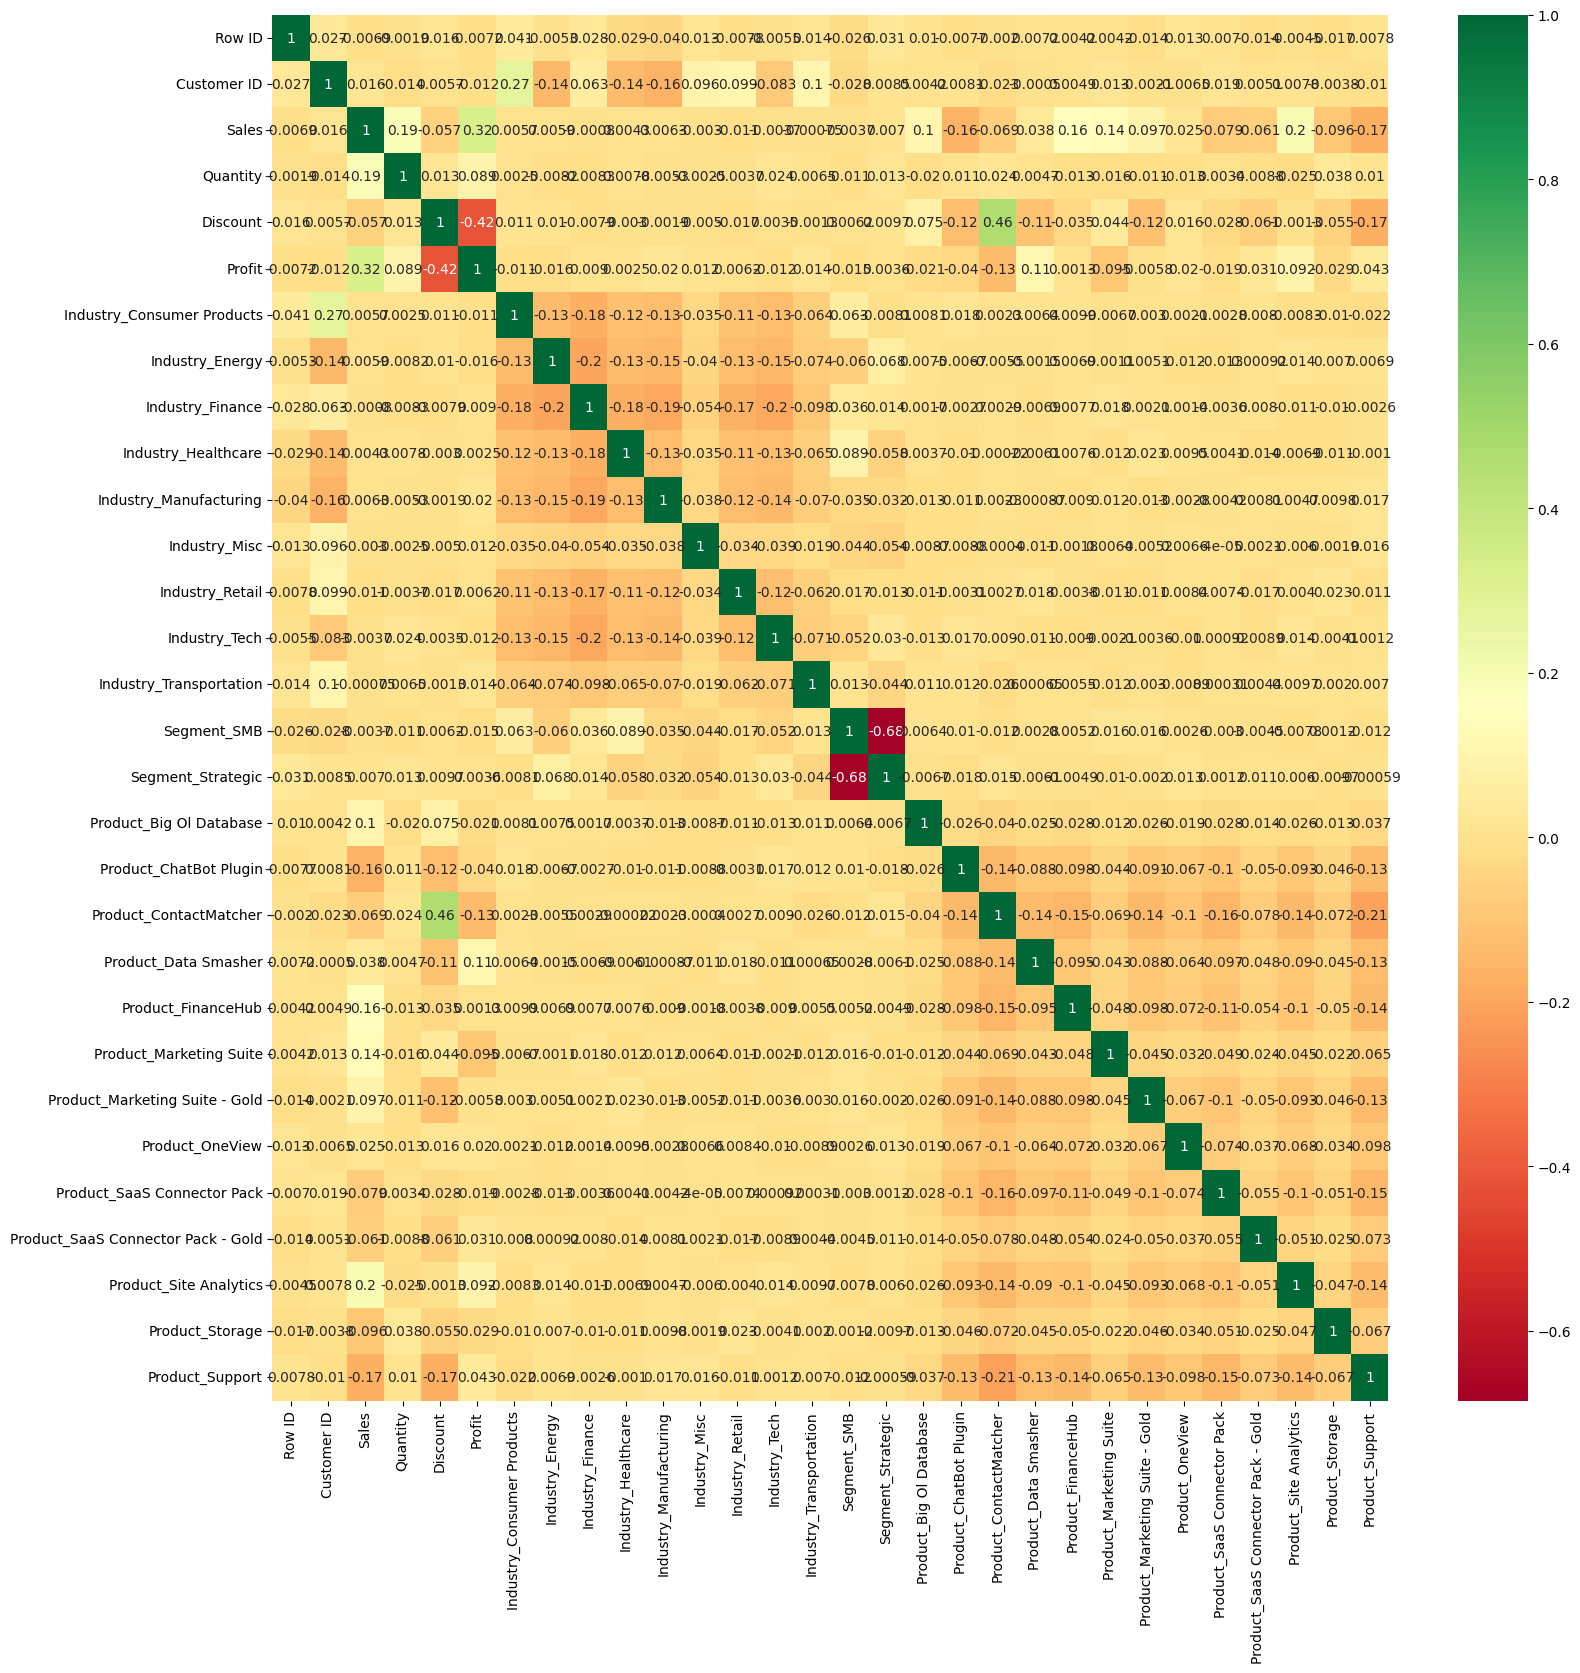

In [66]:
plt.figure(figsize=(18,18))
sns.heatmap(data_encoded_num.corr(),annot=True,cmap='RdYlGn')
plt.show()

This correlation matrix is not as easy to understand, because there are too many variables, but we can see some weak correlations between other variables.

In [67]:
data_encoded_num_corr_sales = data_encoded_num.corr()['Sales']
top_correlated_features_data_encoded = data_encoded_num_corr_sales[abs(data_encoded_num_corr_sales) > 0.05].sort_values(ascending=False) # displays the Pearson Correlation Coefficient greater than the selected trashold
print("There is {} correlated values with Profit:\n{}".format(len(top_correlated_features_data_encoded), top_correlated_features_data_encoded))

There is 15 correlated values with Profit:
Sales                                 1.000000
Profit                                0.322919
Product_Site Analytics                0.198362
Quantity                              0.189362
Product_FinanceHub                    0.161874
Product_Marketing Suite               0.140245
Product_Big Ol Database               0.100861
Product_Marketing Suite - Gold        0.097298
Discount                             -0.056623
Product_SaaS Connector Pack - Gold   -0.060840
Product_ContactMatcher               -0.069462
Product_SaaS Connector Pack          -0.078752
Product_Storage                      -0.096091
Product_ChatBot Plugin               -0.160803
Product_Support                      -0.174676
Name: Sales, dtype: float64


If we analyse the correlation of the different variables with "Sales" we can find some proucts that have a positive weak correlation with both Sales and Profit (e.e, Site Analytics), and a negative weak correlation with both (i.e., Contact Matcher). However, the most interesting result, is the Marketing Suite, which has a positive weak correlation with Sales but a negative weak correlation with Profit.

What we can take away from a shallow analysis of this last product is that AWS may want to eliminate the product or increase its price. However, the priduct might being sold at a loss to penetrate the market, so this loss of profit may be part of a strategy and this should be checked with the relevant stakeholders before drawing any conclusion.

<AxesSubplot: >

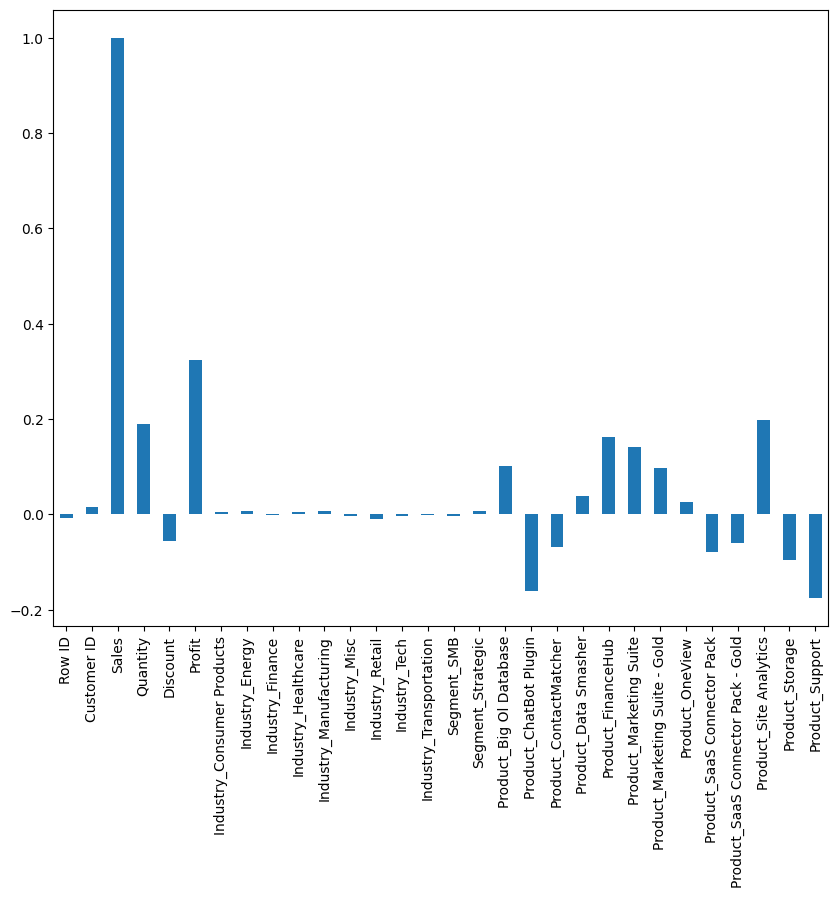

In [68]:
data_encoded_num_corr_sales.plot(kind="bar",figsize=(10,8))

Now that we know what features are the most correlated with Sales and Profit, we can drop any other variable and create a new dataset with those features only.

To do so, we are filtering again the dataset to find what features correlate the most with Profit and Sales.

In [75]:
# Define your correlation threshold
threshold = 0.05

# Find feature names with correlations greater than the threshold for both 'Sales' and 'Profit'
correlated_sales = data_encoded_num_corr_sales[abs(data_encoded_num_corr_sales) > threshold].index
correlated_profit = data_encoded_num_corr_profit[abs(data_encoded_num_corr_profit) > threshold].index

# Get the intersection of these features
top_correlated_features = correlated_sales.union(correlated_profit)

# Now, create a new DataFrame with only these columns from the original DataFrame
# Assuming your original DataFrame is named `data_encoded`
top_correlated_features_data = data_encoded_num[top_correlated_features]
top_correlated_features_data.to_pickle('top_correlated_features_data.pkl')

# View the columns in the new DataFrame
top_correlated_features_data.columns



Index(['Discount', 'Product_Big Ol Database', 'Product_ChatBot Plugin',
       'Product_ContactMatcher', 'Product_Data Smasher', 'Product_FinanceHub',
       'Product_Marketing Suite', 'Product_Marketing Suite - Gold',
       'Product_SaaS Connector Pack', 'Product_SaaS Connector Pack - Gold',
       'Product_Site Analytics', 'Product_Storage', 'Product_Support',
       'Profit', 'Quantity', 'Sales'],
      dtype='object')

Before proceding to the next stage, let's plot the different relationships of the different variables with Profit and Sales.

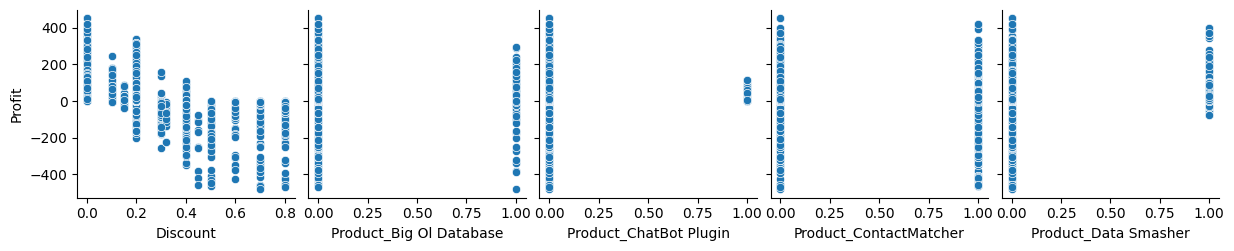

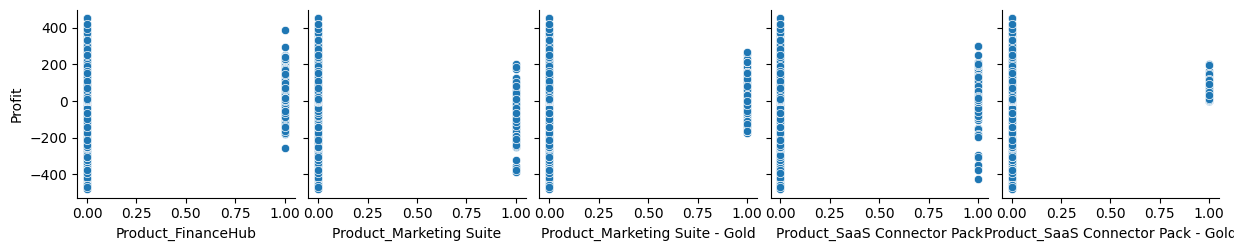

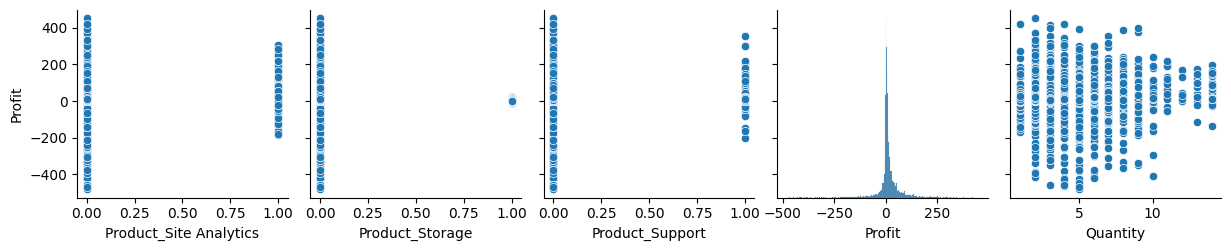

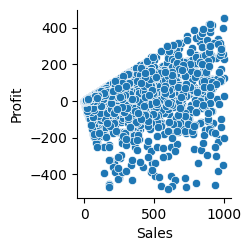

In [4]:
for i in range (0,len(top_correlated_features_data.columns), 5):
    sns.pairplot(data=top_correlated_features_data,
                 x_vars=top_correlated_features_data.columns[i:i+5],
                 y_vars=['Profit'])

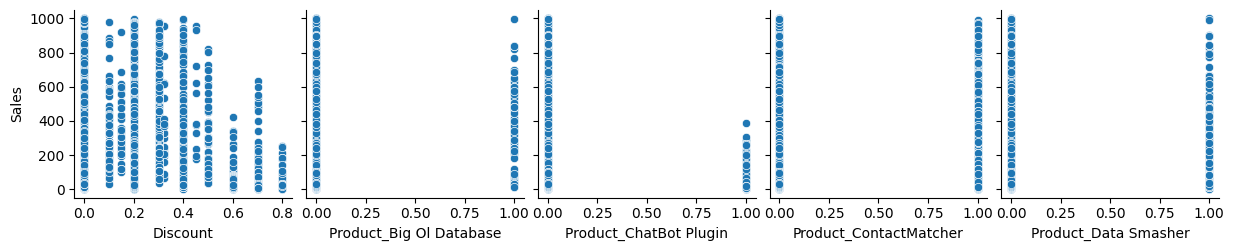

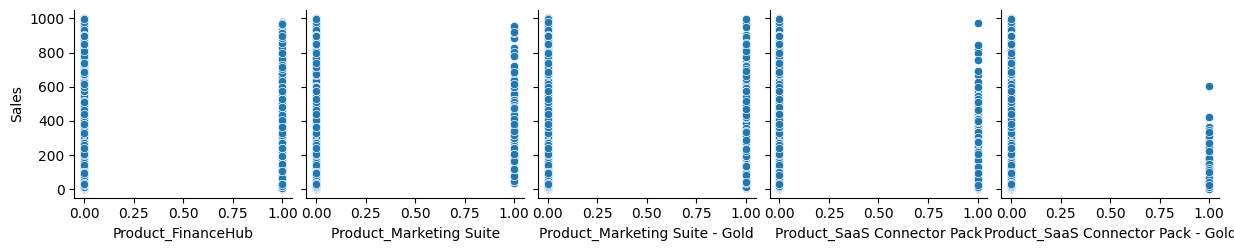

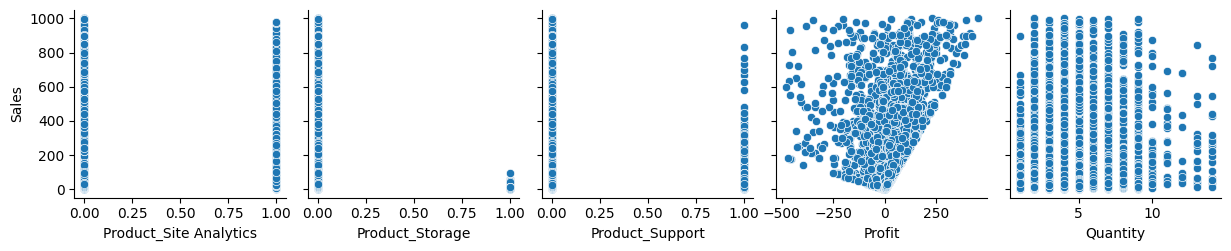

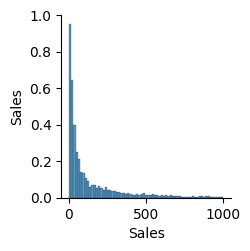

In [5]:
for i in range (0,len(top_correlated_features_data.columns), 5):
    sns.pairplot(data=top_correlated_features_data,
                 x_vars=top_correlated_features_data.columns[i:i+5],
                 y_vars=['Sales'])

## Normalize the data

Now that we have a dataset with only the features of interest, we want to normalize our variables.

In [12]:
top_correlated_features_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9509 entries, 0 to 9993
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Discount                            9509 non-null   float64
 1   Product_Big Ol Database             9509 non-null   int64  
 2   Product_ChatBot Plugin              9509 non-null   int64  
 3   Product_ContactMatcher              9509 non-null   int64  
 4   Product_Data Smasher                9509 non-null   int64  
 5   Product_FinanceHub                  9509 non-null   int64  
 6   Product_Marketing Suite             9509 non-null   int64  
 7   Product_Marketing Suite - Gold      9509 non-null   int64  
 8   Product_SaaS Connector Pack         9509 non-null   int64  
 9   Product_SaaS Connector Pack - Gold  9509 non-null   int64  
 10  Product_Site Analytics              9509 non-null   int64  
 11  Product_Storage                     9509 no

Now we need to choose an appropriate scaler for the data and for what we want to do with it. Here are our choices:

- StandardScaler: It is usually chosen if the continuous variables are normally distributed, or if the model requires normally distributed data, such as linear regression, or if all features need to have the same variance. Not a problem to mix with one-hot encoding, but one needs to be mindful of interpretation.

- MinMaxScaler: It is usually chosen if the continuous variables need to be normalized to the [0, 1] range, which can make them more comparable to one-hot encoded variables in terms of scale. This can be especially useful if one is using algorithms that are sensitive to the magnitude of features, such as neural networks.

- RobustScaler: It is usually chosen if the data has outliers or is not normally distributed. It makes the continuous variables robust to outliers but does not necessarily bring them to the same scale as one-hot encoded features.

We choose Standard Scaler because we want to try linear regression afterward.

In [5]:
# Make a copy of the dataframe to keep the original data intact
standardized_data = top_correlated_features_data.copy()

# Specify the columns to be standardized
columns_to_standardize = ['Profit', 'Sales', 'Discount', 'Quantity']

# Subset the dataframe to select the specified columns for standardization
variables_to_standardize = top_correlated_features_data[columns_to_standardize]

# Perform standardization (z-score normalization) using StandardScaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(variables_to_standardize)

# Add standardized values as new columns to the copy of the original dataframe
for i, col in enumerate(columns_to_standardize):
    standardized_data[f'{col}_standardized'] = scaled_values[:, i]

standardized_data.to_pickle('standardized_data.pkl')

# Check the structure of the standardized data
standardized_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9509 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Discount                            9509 non-null   float64
 1   Product_Big Ol Database             9509 non-null   int64  
 2   Product_ChatBot Plugin              9509 non-null   int64  
 3   Product_ContactMatcher              9509 non-null   int64  
 4   Product_Data Smasher                9509 non-null   int64  
 5   Product_FinanceHub                  9509 non-null   int64  
 6   Product_Marketing Suite             9509 non-null   int64  
 7   Product_Marketing Suite - Gold      9509 non-null   int64  
 8   Product_SaaS Connector Pack         9509 non-null   int64  
 9   Product_SaaS Connector Pack - Gold  9509 non-null   int64  
 10  Product_Site Analytics              9509 non-null   int64  
 11  Product_Storage                     9509 non-nul

In [6]:
standardized_data.describe()

Discount  Product_Big Ol Database  Product_ChatBot Plugin  \
count  9509.000000              9509.000000             9509.000000   
mean      0.156258                 0.007151                0.083605   
std       0.206819                 0.084266                0.276809   
min       0.000000                 0.000000                0.000000   
25%       0.000000                 0.000000                0.000000   
50%       0.200000                 0.000000                0.000000   
75%       0.200000                 0.000000                0.000000   
max       0.800000                 1.000000                1.000000   

       Product_ContactMatcher  Product_Data Smasher  Product_FinanceHub  \
count             9509.000000           9509.000000         9509.000000   
mean                 0.181512              0.078347            0.095173   
std                  0.385462              0.268731            0.293469   
min                  0.000000              0.000000            0.000000   
25%                  0.000000              0.000000            0.000000   
50%                  0.000000              0.000000            0.000000   
75%                  0.000000              0.000000            0.000000   
max                  1.000000              1.000000            1.000000   

       Product_Marketing Suite  Product_Marketing Suite - Gold  \
count              9509.000000                     9509.000000   
mean                  0.021138                        0.084026   
std                   0.143851                        0.277441   
min                   0.000000                        0.000000   
25%                   0.000000                        0.000000   
50%                   0.000000                        0.000000   
75%                   0.000000                        0.000000   
max                   1.000000                        1.000000   

       Product_SaaS Connector Pack  Product_SaaS Connector Pack - Gold  \
count                  9509.000000                         9509.000000   
mean                      0.100116                            0.026712   
std                       0.300170                            0.161248   
min                       0.000000                            0.000000   
25%                       0.000000                            0.000000   
50%                       0.000000                            0.000000   
75%                       0.000000                            0.000000   
max                       1.000000                            1.000000   

       Product_Site Analytics  Product_Storage  Product_Support       Profit  \
count             9509.000000      9509.000000      9509.000000  9509.000000   
mean                 0.086234         0.022820         0.163214    16.100576   
std                  0.280724         0.149339         0.369580    61.167492   
min                  0.000000         0.000000         0.000000  -479.988000   
25%                  0.000000         0.000000         0.000000     1.684800   
50%                  0.000000         0.000000         0.000000     8.046400   
75%                  0.000000         0.000000         0.000000    25.098000   
max                  1.000000         1.000000         1.000000   449.991000   

          Quantity        Sales  Profit_standardized  Sales_standardized  \
count  9509.000000  9509.000000         9.509000e+03        9.509000e+03   
mean      3.681775   136.382930        -4.483391e-18       -5.678962e-17   
std       2.153918   194.742657         1.000053e+00        1.000053e+00   
min       1.000000     0.444000        -8.110757e+00       -6.980806e-01   
25%       2.000000    16.032000        -2.356895e-01       -6.180323e-01   
50%       3.000000    47.952000        -1.316811e-01       -4.541151e-01   
75%       5.000000   170.352000         1.471026e-01        1.744397e-01   
max      14.000000   999.980000         7.093854e+00        4.434788e+00   

       Discount_standardiz

## EDA and preprocessing conclusions

In this EDA and preprocessing phase we identified a primary target variable "Profit" and some other variables that weakly correlate. We have also identified some products that are positively and negatively correlated with Profit and Sales, but most surprisingly we have found that the Marketing Hub positively correlates with sales, but negatively correlates with profitability. This might part of a strategy and relevant stakeholders should be able to tell weather this is a strategy to get market share or weather prices should be increased.

Moreover, we have also found out that in the low Sales area, AWS has very little profitability, we more deals resulting in zero or little profit, indicating that some deals are making the company lose money or no money at all. However, luckily, most sales result into a profit.

In the last part of the notebook we preprocessed the data, removed some outlayers, and performed one hot encoding on the categorical variables and standardization on the continuous variables. Then we selected the independent variables that have at least some weak correlation to our dependend variable (Profit), such as Sales, Quantity, Discount, and some of the products.

Even if we don't have any strong correlation to the target variable, and therefore it might not be possible to perform a satisfactory linear regression, in the next notebook we will check if the data satisfies the requirements for linear regression, and if yes, attempt it.